# 将multi-task作为loss function的比较试验 21.11.15

In [3]:
#比较物理信息位于loss function和feature engineering对结果的影响
#                   loss function                        feature engineering
# physicsinformed1: remain_life                          physics_wear  milling_condition
# compare:                                               physics_wear  milling_condition
# without:                                               remain_life  physics_wear  milling_condition
# phywear:          physics_wear                         remain_life  milling_condition
# life_phywear:     remain_life,  physics_wear           milling_condition
# all:              remain_life, physics_wear, milling_condition

## compare 比较有无multi-task对结果的影响

In [1]:
# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB
# LSTM + local attention + global attention
# train_data1， train_label1， test_data1， test_label1， physicsinformed1_model， physicsinformed1_model2表示physics-label one-hot

import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time
%load_ext tensorboard

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

file_index = 8
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径
SUMMARY_PATH = 'logs'     #记录路径

DOCUMENT_RESULT_PATH = 'results/comparation/loss function/'+str(file_index)+'/'
MODEL_SAVE_PATH = DOCUMENT_RESULT_PATH + 'compare_model.h5'

#信号层级关系
SIGNAL_LENGTH_1 = 1536
SIGNAL_LENGTH_2 = 64
SIGNAL_LENGTH_3 = 8

#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

LOWFREQ_INPUT_SIZE = [int(SIGNAL_LENGTH_1/8), 3]
LOWFREQ_LSTM_SIZE = 13
LOWFREQ_FEATURE_SIZE = 15
ATTENTION_SIZE = 18

HIGHFREQ_INPUT_SIZE = [SIGNAL_LENGTH_1, 3]
HIGHFREQ_LSTM_SIZE = 15
# LOWFREQ_FEATURE_SIZE = ATTENTION_SIZE
ATTENTION_RANGE = 24
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
SAMPLING_STEP = LOWFREQ_INPUT_SIZE[0]//SIGNAL_LENGTH_2

PHYSICS_INPUT_SIZE =6 #输入local的物理条件[拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
PHYSICS_CONCATE1_SIZE = 18 #作为query的输入，包括物理条件和信号的均值和方差
LOCAL_INPUT_SIZE = [SIGNAL_LENGTH_2, LOWFREQ_FEATURE_SIZE+ATTENTION_SIZE]
LOCAL_TIMESTEP = SIGNAL_LENGTH_2//SIGNAL_LENGTH_3

LOCAL_DENSE_SIZE = 25
LOCAL_QUERY_SIZE = LOCAL_DENSE_SIZE

GLOBAL_INPUT_SIZE = [SIGNAL_LENGTH_3, LOCAL_DENSE_SIZE]
GLOBAL_LSTM_SIZE = 25
GLOBAL_DENSE_SIZE = 36
GLOBAL_QUERY_SIZE = GLOBAL_DENSE_SIZE

PHYSICS_RESHAPE_SIZE = [6, 6]
PHYSICS_ATT_SIZE = 20
WEAR_DENSE_SIZE = 150
WEAR_SIZE = 1

BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH = 9

learning_rate = np.array([1, 0.3, 0.1, 0.8, 0.27, 0.1, 
                 0.64, 0.24, 0.1, 0.51, 0.22, 0.1,
                 0.41, 0.20, 0.1, 0.33, 0.18, 0.1,
                 0.26, 0.16, 0.1])*0.01

weight_rate = np.array([0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 
                        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    
######################################################## 数据集构建 #######################################################################
# X_train [样本总量，样本长度，信号维度]
# Y_train [磨损标签，拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
X_train_set=np.load(TRAINDATA_LOADPATH)
Y_train_set = np.load(TRAINLABEL_LOADPATH)
Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
X_test_set=np.load(TESTDATA_LOADPATH)
Y_test_set = np.load(TESTLABEL_LOADPATH)
Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

print('X_train', np.shape(X_train), np.min(X_train), np.max(X_train))
print('PHY_train', np.shape(PHY_train), np.min(PHY_train, axis=0), np.max(PHY_train, axis=0))
print('Y_train', np.shape(Y_train), np.min(Y_train), np.max(Y_train))
print('X_test', np.shape(X_test))
print('PHY_test', np.shape(PHY_test))
print('Y_test', np.shape(Y_test))

################################################ 小波分析 ####################################################################################
def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
coeffs_lowfreq_train = coeffs_train_force[0]
coeffs_highfreq_train = coeffs_train_force[1]
print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train), np.min(coeffs_lowfreq_train), np.max(coeffs_lowfreq_train))
print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train), np.min(coeffs_highfreq_train), np.max(coeffs_highfreq_train))

coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
coeffs_lowfreq_test = coeffs_test_force[0]
coeffs_highfreq_test = coeffs_test_force[1]
print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test), np.min(coeffs_lowfreq_test), np.max(coeffs_lowfreq_test))
print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test), np.min(coeffs_highfreq_test), np.max(coeffs_highfreq_test))

######################################################### 模型搭建 ##################################################################
def mean_input_layer(x):#将输入的均值与预测器的特征拼接
    y = backend.mean(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y
def var_input_layer(x):#将输入的方差与预测器的特征拼接
    y = backend.var(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y

def lowfreq_model_construct(input_size, rnn_size, output_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='lowfreq_inputs')
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)
    x = layers.Lambda(lambda x: x[:, ::ATTENTION_RANGE//8])(x)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
    outputs = layers.TimeDistributed(layers.Dense(output_size))(x)
    outputs = layers.BatchNormalization(trainable=False)(outputs)
#     outputs = layers.BatchNormalization()(outputs)
    outputs = layers.LeakyReLU()(outputs)
    query = layers.TimeDistributed(layers.Dense(attention_size))(x)
    query = layers.LayerNormalization(axis = 1)(query)
    query = layers.LeakyReLU()(query)
    model_lowfreq = models.Model(inputs=inputs, outputs=[outputs, query], name = name)
    return model_lowfreq

def highfreq_model_construct(input_size, rnn_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='highfreq_inputs')
#     x = layers.Lambda(adjust_range, name = 'adjust_range')(inputs)
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)#, recurrent_regularizer=regularizers.l1(0.000001)
    key = layers.TimeDistributed(layers.Dense(attention_size))(x)
    key = layers.LayerNormalization(axis = 1)(key)
    key = layers.LeakyReLU()(key)
    value = layers.TimeDistributed(layers.Dense(attention_size))(x)
    value = layers.LayerNormalization(axis = 1)(value)
    value = layers.LeakyReLU()(value)
    model_highfreq = models.Model(inputs=inputs, outputs=[key, value], name = name)
    return model_highfreq

class lowhigh_freq_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
#         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
        scores = tf.matmul(query, key, transpose_b=True)
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.matmul(distribution, value)
#         print('value_weighted1', np.shape(value_weighted))
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
#         print('value_weighted2', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape
    
class temporal_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(temporal_Attention,self).build(input_shape)
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
#         print('query', np.shape(query))
#         print('self.u_query', np.shape(self.u_query))
        key = x[:, 1:]
        scores1 = tf.matmul(query, key, transpose_b=True)
#         print('scores1', np.shape(scores1))
        scores2 = tf.matmul(self.u_query, key, transpose_b=True)
#         print('scores2', np.shape(scores2))
        scores = scores1 + scores2
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
#         print('value_weighted1', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape
    
def localLSTM_construct(input_size, physics_size, timestep, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    inputs_query = layers.Input(shape=physics_size, batch_size = BATCH_SIZE, name='inputs_query')
    query = layers.Dense(dense_size)(inputs_query)
    query = layers.LeakyReLU()(query)
    query = layers.Reshape([1, 1, dense_size])(query)
    query = layers.Concatenate(axis = 1)([query, query, query, query, query, query, query, query])
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.Reshape([int(input_size[0]/timestep), timestep, dense_size])(x)
    x = layers.LayerNormalization(axis = 2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Concatenate(axis = 2)([query, x])
    outputs, att_distribution_local = layers.TimeDistributed(temporal_Attention())(x)
    biLSTM_model = models.Model(inputs=[inputs, inputs_query], outputs=[outputs, att_distribution_local], name = name)
    return biLSTM_model

def globalLSTM_construct(input_size, physics_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    inputs_query = layers.Input(shape=physics_size, batch_size = BATCH_SIZE, name='inputs_query')
    query = layers.Dense(dense_size)(inputs_query)
    query = layers.LeakyReLU()(query)
    query = layers.Reshape([1, dense_size])(query)
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.LayerNormalization(axis = 1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Concatenate(axis = 1)([query, x])
    outputs, att_distribution_global = temporal_Attention()(x)
    biLSTM_model = models.Model(inputs=[inputs, inputs_query], outputs=[outputs, att_distribution_global], name = name)
    return biLSTM_model

def multiply_construct(input_feature_size, feature_reshape_size, input_physics_size, dense_att_size, name):
    inputs_feature = layers.Input(shape=input_feature_size, batch_size = BATCH_SIZE, name='inputs_feature')
    feature = layers.Reshape(feature_reshape_size)(inputs_feature)
    feature = layers.TimeDistributed(layers.Dense(dense_att_size, activation = 'tanh'))(feature)
    inputs_physics = layers.Input(shape=input_physics_size, batch_size = BATCH_SIZE, name='inputs_physics')
    physics = layers.Dense(dense_att_size, activation = 'tanh')(inputs_physics)
    physics = layers.Reshape([1, dense_att_size])(physics)
    outputs = layers.Attention(use_scale=False)([physics, feature])
    outputs = layers.Reshape([dense_att_size])(outputs)
    multiply_model = models.Model(inputs=[inputs_feature, inputs_physics], outputs=outputs, name = name)
    return multiply_model

#这里将物理模型的输出与信号的平均值和方差作为提示特征
#低频
input_lowfreq = layers.Input(shape=LOWFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_lowfreq')
mean_lowfreq = layers.Lambda(mean_input_layer, name = 'mean_lowfreq')(input_lowfreq)
var_lowfreq = layers.Lambda(var_input_layer, name = 'var_lowfreq')(input_lowfreq)
# input_lowfreq1 = layers.BatchNormalization()(input_lowfreq)
input_lowfreq1 = layers.BatchNormalization(trainable=False)(input_lowfreq)
#高频
input_highfreq = layers.Input(shape=HIGHFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_highfreq')
mean_highfreq = layers.Lambda(mean_input_layer, name = 'mean_highfreq')(input_highfreq)
var_highfreq = layers.Lambda(var_input_layer, name = 'var_highfreq')(input_highfreq)
input_highfreq1 = layers.BatchNormalization(trainable=False)(input_highfreq)
# input_highfreq1 = layers.BatchNormalization()(input_highfreq)
#提示特征
input_physics = layers.Input(shape=PHYSICS_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_physics')
print('mean_lowfreq', np.shape(mean_lowfreq), 'mean_highfreq', np.shape(mean_highfreq), 'input_physics', np.shape(input_physics))
input_physics1 = layers.Concatenate(axis = 1)([mean_lowfreq, var_lowfreq, mean_highfreq, var_highfreq, input_physics])#提示特征
# print('input_physics1', np.shape(input_physics1))

model_lowfreq = lowfreq_model_construct(LOWFREQ_INPUT_SIZE, LOWFREQ_LSTM_SIZE, LOWFREQ_FEATURE_SIZE, ATTENTION_SIZE, 'lowfreq_model')
model_highfreq = highfreq_model_construct(HIGHFREQ_INPUT_SIZE, HIGHFREQ_LSTM_SIZE, ATTENTION_SIZE, 'highfreq_model')
# 低频特征构造query，高频特征构造key和value，构建低频特征向高频特征的注意力模型，使高低频长度一致并对齐
feature_lowfreq, query = model_lowfreq(input_lowfreq1)
# feature_lowfreq = layers.Lambda(lambda x: x[:, ::6])(feature_lowfreq)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
# query = layers.Lambda(lambda x: x[:, ::6])(query)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
key, value = model_highfreq(input_highfreq1)

#高低频注意力机制
query = layers.Reshape([-1, 1, ATTENTION_SIZE])(query)
value = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(value)
key = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(key)
concate_vector = layers.Concatenate(axis = 2)([query, value, key])
feature_highfreq, att_distribution_lowhigh = layers.TimeDistributed(lowhigh_freq_Attention())(concate_vector)
# feature_highfreq = layers.BatchNormalization()(feature_highfreq)
feature_highfreq = layers.BatchNormalization(trainable=False)(feature_highfreq)
feature_freq = layers.Concatenate(axis = 2)([feature_lowfreq, feature_highfreq])
print('feature_freq', np.shape(feature_freq))

#local attention
biLSTM_local = localLSTM_construct(LOCAL_INPUT_SIZE, PHYSICS_CONCATE1_SIZE, LOCAL_TIMESTEP, LOCAL_DENSE_SIZE, 'biLSTM_local')
feature_local, att_distribution_local = biLSTM_local([feature_freq, input_physics1])
feature_local = layers.BatchNormalization(trainable=False)(feature_local)
# feature_local = layers.BatchNormalization()(feature_local)
print('feature_local', feature_local)

#global attention
biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, PHYSICS_CONCATE1_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
# biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_LSTM_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
feature, att_distribution_global = biLSTM_global([feature_local, input_physics1])
print('feature', np.shape(feature))

#physics dense
multiply_physics = multiply_construct(GLOBAL_DENSE_SIZE, PHYSICS_RESHAPE_SIZE, PHYSICS_INPUT_SIZE, PHYSICS_ATT_SIZE, 'physics')
physics_feature = multiply_physics([feature, input_physics])
physics_feature = layers.Reshape([PHYSICS_ATT_SIZE])(physics_feature)
print('physics_feature', np.shape(physics_feature))

#tool wear predict
x = layers.Dense(WEAR_DENSE_SIZE)(physics_feature)
x = layers.BatchNormalization(trainable=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
wear_predict = layers.Dense(WEAR_SIZE, activation = 'sigmoid', name='wear_predict')(x)

predictor = models.Model(inputs=[input_lowfreq, input_highfreq, input_physics], 
                         outputs=wear_predict, name='tool_wear_predictor')
predictor.summary()

#############################################模型训练#########################################################################
time_start = time.time()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=SUMMARY_PATH, histogram_freq=1)
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='wear_predict',  save_best_only=True, mode='max')
for i in range(PREDICTOR_TRAIN_BATCH):
    print('##########'+str(i+1)+'############')
    adam = keras.optimizers.Adam(lr=learning_rate[i])
    predictor.compile(optimizer=adam, loss = 'mse')
    history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train[:, :-1]], Y_train, batch_size=BATCH_SIZE, 
                            validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test[:, :-1]], Y_test), 
                            epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])
    
predictor.save(MODEL_SAVE_PATH)
print('time1 =  ', time.time()-time_start)

X_train (9728, 1536, 3) -0.9293552041053772 0.8662327527999878
PHY_train (9728, 7) [1.8072429e-01 6.0000002e-01 6.0000002e-01 3.3333334e-01 2.0000000e-01
 2.0000000e-01 3.8910506e-04] [0.863643   1.         1.         1.         1.         1.
 0.99833196]
Y_train (9728,) 0.18163076 0.87186223
X_test (1088, 1536, 3)
PHY_test (1088, 7)
Y_test (1088,)
coeffs_lowfreq_train (9728, 192, 3) -1.6887109675302232 1.6770890508760357
coeffs_highfreq_train (9728, 1536, 3) -0.6074406355435511 0.6436477411157987
coeffs_lowfreq_test (1088, 192, 3) -1.5425268591451757 1.6827855264342724
coeffs_highfreq_test (1088, 1536, 3) -0.8581441584885379 0.6740121754985141
mean_lowfreq (64, 3) mean_highfreq (64, 3) input_physics (64, 6)
feature_freq (64, 64, 33)
feature_local KerasTensor(type_spec=TensorSpec(shape=(64, 8, 25), dtype=tf.float32, name=None), name='batch_normalization_4/batchnorm/add_1:0', description="created by layer 'batch_normalization_4'")
feature (64, 36)
physics_feature (64, 20)
Model: "tool_w

##########2############
152/152 [==============================] - 82s 486ms/step - loss: 9.5844e-04 - val_loss: 4.4976e-04
##########3############
152/152 [==============================] - 81s 482ms/step - loss: 3.9551e-04 - val_loss: 4.6844e-04
##########4############
152/152 [==============================] - 80s 471ms/step - loss: 0.0048 - val_loss: 0.0012
##########5############
152/152 [==============================] - 79s 460ms/step - loss: 7.8504e-04 - val_loss: 8.6916e-04
##########6############
152/152 [==============================] - 82s 486ms/step - loss: 2.8117e-04 - val_loss: 5.8038e-04
##########7############
152/152 [==============================] - 85s 498ms/step - loss: 0.0018 - val_loss: 5.1230e-04
##########8############
152/152 [==============================] - 82s 493ms/step - loss: 4.7178e-04 - val_loss: 4.9960e-04
##########9############
152/152 [==============================] - 84s 504ms/step - loss: 2.0760e-04 - val_loss: 7.3723e-04
time1 =   742.605475

### 结果显示

wear_pre_train (9728, 1)
loss_train_avg 0.00014066599
percent_train_avg 2.151395194232464 %


<Figure size 1080x432 with 0 Axes>

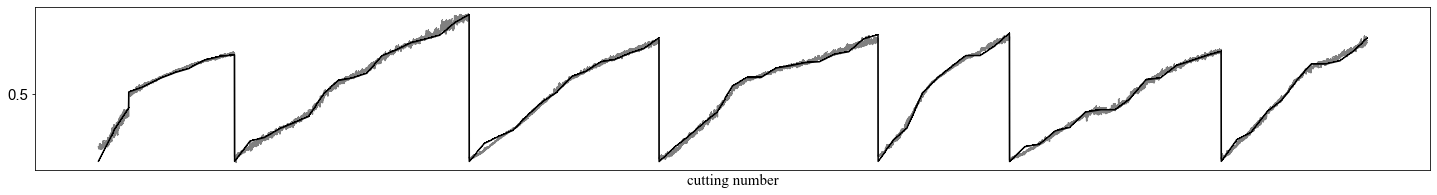

time1 =   3.0338828563690186 sample_num 1088
loss_test_avg 0.0016034852
percent_test_avg 7.186954468488693 %


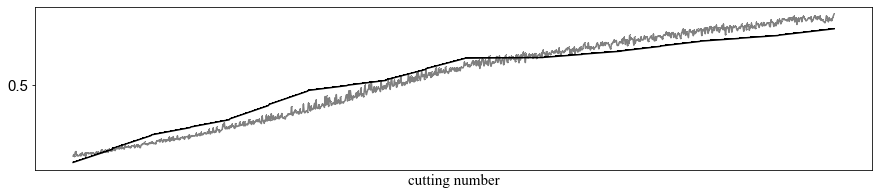

In [2]:
#
import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time

file_index = 2
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径

DOCUMENT_RESULT_PATH = 'results/comparation/loss function/'+str(file_index)+'/'
MODEL_LOADPATH = DOCUMENT_RESULT_PATH + 'compare_model.h5'
PHYSICINFOMED_SAVEPATH = DOCUMENT_RESULT_PATH + 'compare_result.npy'

    
load_flag = 1 ########################################1:重新加载模型，0：不加载##########################

if load_flag == 1:
    #信号层级关系
    SIGNAL_LENGTH_1 = 1536
    SIGNAL_LENGTH_2 = 64
    SIGNAL_LENGTH_3 = 8

    #输入数据
    INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
    INPUT_NUM = INPUT_SIZE[1]
    SCALE_NUM_FORCE = 3 #小波分解级数
    WAVELET_HIGHFREQ = 'db2'
    WAVELET_LOWFREQ = 'db6'
    # NOISE_FILTER_PERCENT = 90
    ATTENTION_RANGE = 24
    WEAR_SIZE = 1
    LIFE_SIZE = 1
    BATCH_SIZE = 64

    def wavelet_transform(data, scale_num):
        coeffs = np.arange(2).tolist()
        for j in range(np.shape(data)[2]):
            sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
            coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
            coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
            coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
            coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
    #         for i in range(1, scale_num+1):       #高频去噪
    #             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
            coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

            if j == 0:
                coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
                coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
            else:
                coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
                coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
        return coeffs

    class lowhigh_freq_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(lowhigh_freq_Attention,self).build(input_shape)
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
            value = x[:, 1:ATTENTION_RANGE+1]
            key = x[:, ATTENTION_RANGE+1:]
    #         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
            scores = tf.matmul(query, key, transpose_b=True)
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.matmul(distribution, value)
    #         print('value_weighted1', np.shape(value_weighted))
            value_weighted = tf.reduce_sum(value_weighted, axis=1)
    #         print('value_weighted2', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape

    class temporal_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(temporal_Attention,self).build(input_shape)
            self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
    #         print('query', np.shape(query))
    #         print('self.u_query', np.shape(self.u_query))
            key = x[:, 1:]
            scores1 = tf.matmul(query, key, transpose_b=True)
    #         print('scores1', np.shape(scores1))
            scores2 = tf.matmul(self.u_query, key, transpose_b=True)
    #         print('scores2', np.shape(scores2))
            scores = scores1 + scores2
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
    #         print('value_weighted1', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape

    X_train_set=np.load(TRAINDATA_LOADPATH)
    Y_train_set = np.load(TRAINLABEL_LOADPATH)
    Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
    X_test_set=np.load(TESTDATA_LOADPATH)
    Y_test_set = np.load(TESTLABEL_LOADPATH)
    Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

    #validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
    X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
    Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
    PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
    X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
    PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

    coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
    coeffs_lowfreq_train = coeffs_train_force[0]
    coeffs_highfreq_train = coeffs_train_force[1]
    coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
    coeffs_lowfreq_test = coeffs_test_force[0]
    coeffs_highfreq_test = coeffs_test_force[1]  

    ################################################### 模型读取及预测 ##################################################
    predictor = keras.models.load_model(MODEL_LOADPATH, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                         'temporal_Attention':temporal_Attention})
    
################################################### 波形显示 ##################################################
fig_x = 15
fig_y = 6
size = 15
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}

#train
# score = predictor.evaluate([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train], Y_train, verbose=0, batch_size = BATCH_SIZE)
wear_pre_train = predictor.predict([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train[:, :-1]], batch_size = BATCH_SIZE)
print('wear_pre_train', np.shape(wear_pre_train))

axis = np.linspace(1, np.shape(wear_pre_train)[0], np.shape(wear_pre_train)[0])
print('loss_train_avg', np.mean(np.square(wear_pre_train[:, 0] - Y_train)))
print('percent_train_avg', np.mean(np.abs(wear_pre_train[:, 0] - Y_train)/Y_train)*100, '%')
plt.figure(figsize=(25, 3))
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_train[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_train, marker = ',', color = 'black')
plt.show()

#test
time_start = time.time()
wear_pre_test = predictor.predict([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test[:, :-1]], batch_size = BATCH_SIZE)
print('time1 =  ', time.time()-time_start, 'sample_num', np.shape(coeffs_lowfreq_test)[0])

axis = np.linspace(1, np.shape(wear_pre_test)[0], np.shape(wear_pre_test)[0])
print('loss_test_avg', np.mean(np.square(wear_pre_test[:, 0] - Y_test)))
print('percent_test_avg', np.mean(np.abs(wear_pre_test[:, 0] - Y_test)/Y_test)*100, '%')
plt.figure(figsize=(15, 3))
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_test[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_test, marker = ',', color = 'black')
plt.show()

np.save(PHYSICINFOMED_SAVEPATH, wear_pre_test[:, 0])


1
mAPE
baseline:  4.935337603092194 %
compare:  8.925865590572357 %
mFPE
baseline:  1.9678411 um
compare:  4.2858663 um
MFPE
baseline:  10.981909 um
compare:  9.412134 um


2
mAPE
baseline:  4.480458423495293 %
compare:  7.1869537234306335 %
mFPE
baseline:  2.1228597 um
compare:  3.5562348 um
MFPE
baseline:  5.4849663 um
compare:  8.744427 um


3
mAPE
baseline:  5.308020859956741 %
compare:  6.900151818990707 %
mFPE
baseline:  3.02234 um
compare:  4.0614653 um
MFPE
baseline:  8.56852 um
compare:  16.877922 um


4
mAPE
baseline:  4.457409679889679 %
compare:  4.3356191366910934 %
mFPE
baseline:  2.098462 um
compare:  1.8069527 um
MFPE
baseline:  6.7741394 um
compare:  7.1205482 um


5
mAPE
baseline:  4.733693599700928 %
compare:  7.627683877944946 %
mFPE
baseline:  2.402458 um
compare:  3.8823826 um
MFPE
baseline:  8.368362 um
compare:  13.8984375 um


6
mAPE
baseline:  5.732260271906853 %
compare:  4.498954117298126 %
mFPE
baseline:  1.8814876 um
compare:  2.0682333 um
MFPE
baseline:  

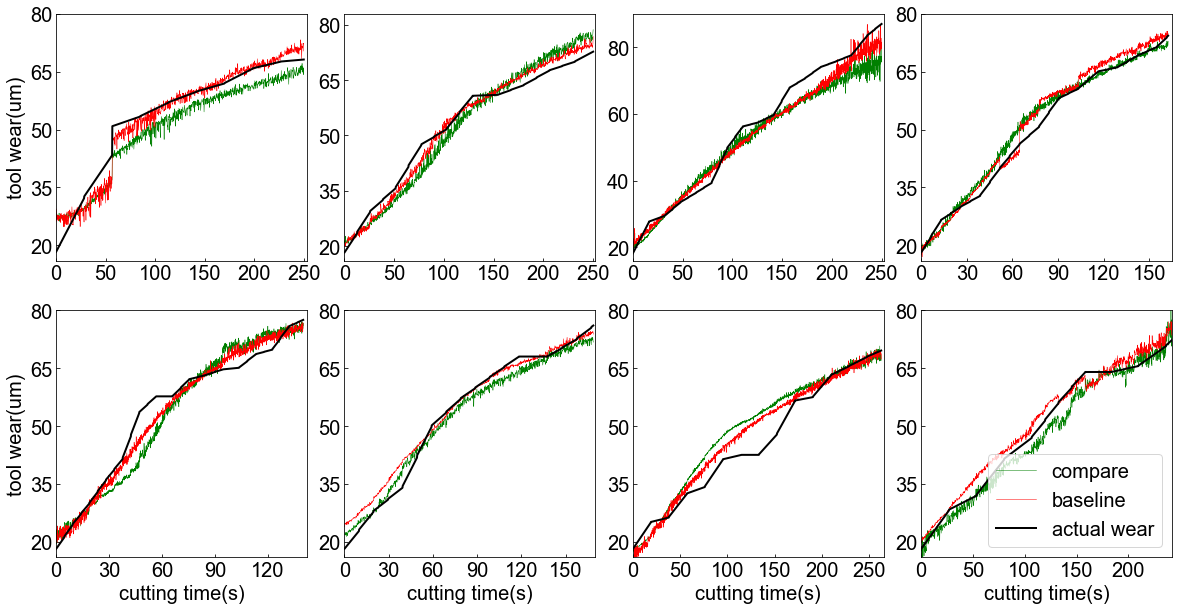

baseline: mAPE,  5.298972548916936 % mFPE 2.3424732983112335 um MFPE 7.770420789718628 um
compare: mAPE,  6.792930467054248 % mFPE 3.245173901319504 um MFPE 10.083177328109741 um


In [4]:
#leave-one-out输出

import pywt
import numpy as np
import matplotlib.pyplot as plt
import xlrd

BASELINE_LOADPATH = ['results/prediction/1/physicsinformed1_result.npy', 'results/prediction/2/physicsinformed1_result.npy',
                     'results/prediction/3/physicsinformed1_result.npy', 'results/prediction/4/physicsinformed1_result.npy',
                     'results/prediction/5/physicsinformed1_result.npy', 'results/prediction/6/physicsinformed1_result.npy', 
                     'results/prediction/7/physicsinformed1_result.npy', 'results/prediction/8/physicsinformed1_result.npy']
DOCUMENT_RESULT_PATH = 'results/comparation/loss function/'
COMPARE_LOADPATH = [DOCUMENT_RESULT_PATH +'/1/compare_result.npy', DOCUMENT_RESULT_PATH +'/2/compare_result.npy', 
                    DOCUMENT_RESULT_PATH +'/3/compare_result.npy', DOCUMENT_RESULT_PATH +'/4/compare_result.npy', 
                    DOCUMENT_RESULT_PATH +'/5/compare_result.npy', DOCUMENT_RESULT_PATH +'/6/compare_result.npy', 
                    DOCUMENT_RESULT_PATH +'/7/compare_result.npy', DOCUMENT_RESULT_PATH +'/8/compare_result.npy']
LABEL_LOADPATH = ['dataset/dataset1/test_label1.npy', 'dataset/dataset2/test_label1.npy', 'dataset/dataset3/test_label1.npy', 
                  'dataset/dataset4/test_label1.npy', 'dataset/dataset5/test_label1.npy', 'dataset/dataset6/test_label1.npy', 
                  'dataset/dataset7/test_label1.npy', 'dataset/dataset8/test_label1.npy']

FIG_SAVEPATH = 'results/comparation/loss function/test_train_result.svg'
BATCH_SIZE = 64


CUTTING_TIME = [250, 250, 250, 162.5, 140, 168.75, 262.5, 250]
xlim = {'1': 253, '2': 252, '3': 252, '4': 165,
         '5': 142, '6': 170,'7': 265, '8': 242}
ylim = {'1': [16, 80], '2': [16, 83], '3': [16, 90], '4': [16, 80],
         '5': [16, 80], '6': [16, 80], '7': [16, 80], '8': [16, 80]}
xticks = {'1': [0, 50, 100, 150, 200, 250], '2': [0, 50, 100, 150, 200, 250],
         '3': [0, 50, 100, 150, 200, 250], '4': [0, 30, 60, 90, 120, 150],
         '5': [0, 30, 60, 90, 120, 150], '6': [0, 30, 60, 90, 120, 150],
         '7': [0, 50, 100, 150, 200, 250], '8': [0, 50, 100, 150, 200, 250]}
yticks = {'1': [20, 35, 50, 65, 80], '2': [20, 35, 50, 65, 80],
         '3': [20, 40, 60, 80, 100], '4': [20, 35, 50, 65, 80],
         '5': [20, 35, 50, 65, 80], '6': [20, 35, 50, 65, 80],
         '7': [20, 35, 50, 65, 80], '8': [20, 35, 50, 65, 80]}

x_y_label_size = 20
x_y_stick_size = 20
font = {'family':'Arial', 'weight':'normal', 'size':20}
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.15, hspace=0.2)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

storage_list = np.zeros([8, 15])
for file_index in range(1, 9):
    #磨损标签
    Y_test_set = np.load(LABEL_LOADPATH[file_index-1])
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]*1000
    #信息融合模型结果
    baseline_result = np.load(BASELINE_LOADPATH[file_index-1]) * 100
    compare_result = np.load(COMPARE_LOADPATH[file_index-1]) * 100
    
    print(file_index)
    print('mAPE')
    baseline = np.mean(np.abs((baseline_result - Y_test)/Y_test))*100
    compare = np.mean(np.abs((compare_result - Y_test)/Y_test))*100
    storage_list[file_index-1, :2] = np.array([baseline, compare])
    print('baseline: ', baseline, '%')
    print('compare: ', compare, '%')
    
    print('mFPE')
    baseline = np.mean(np.abs(baseline_result - Y_test))
    compare = np.mean(np.abs(compare_result - Y_test))
    storage_list[file_index-1, 2:4] = np.array([baseline, compare])
    print('baseline: ', baseline, 'um')
    print('compare: ', compare, 'um')
    
    print('MFPE')
    baseline = np.max(np.abs(baseline_result - Y_test))
    compare = np.max(np.abs(compare_result - Y_test))
    storage_list[file_index-1, 4:6] = np.array([baseline, compare])
    print('baseline: ', baseline, 'um')
    print('compare: ', compare, 'um')
    print('\n')

    plt.subplot(2,4,file_index)
    axis = np.linspace(0, CUTTING_TIME[file_index-1], num=np.shape(Y_test)[0]+1)[1:]
#     plt.plot(axis, without_result, linewidth=0.5, color='blue', label = 'without')
#     plt.plot(axis, phywear_result, linewidth=0.5, color='green', label = 'phywear')
#     plt.plot(axis, life_phywear_result, linewidth=0.5, color='purple', label = 'life phywear')
#     plt.plot(axis, all_result, linewidth=1, color='blue', label = 'all')
    plt.plot(axis, compare_result,linewidth=0.5, color='green', label = 'compare')
    plt.plot(axis, baseline_result,linewidth=0.5, color='red', label = 'baseline')
    plt.plot(axis, Y_test, linewidth=2, color='black', label = 'actual wear')
    
    if file_index-1 == 4 or file_index-1 == 5 or file_index-1 == 6 or file_index-1 == 7:
        plt.xlabel('cutting time(s)', font)
    if file_index-1 == 0 or file_index-1 == 4:
        plt.ylabel('tool wear(um)', font)
    plt.tick_params(labelsize=x_y_label_size) #坐标及刻度设置
    plt.xticks(xticks[str(file_index)], fontproperties = 'Arial', size = x_y_stick_size)
    plt.yticks(yticks[str(file_index)], fontproperties = 'Arial', size = x_y_stick_size)
    plt.xlim(xmin=0, xmax=xlim[str(file_index)]), plt.ylim(ymin=ylim[str(file_index)][0], ymax=ylim[str(file_index)][1])
    if file_index-1 == 7:
        plt.legend(prop = font)
plt.savefig(FIG_SAVEPATH, bbox_inches='tight')#无空白边界
plt.show()


averge_index = np.mean(storage_list, axis = 0)
print('baseline: mAPE, ', averge_index[0], '%', 'mFPE', averge_index[2], 'um', 'MFPE', averge_index[4], 'um')
print('compare: mAPE, ', averge_index[1], '%', 'mFPE', averge_index[3], 'um', 'MFPE', averge_index[5], 'um')

## without

In [3]:
# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB
# LSTM + local attention + global attention
# train_data1， train_label1， test_data1， test_label1， physicsinformed1_model， physicsinformed1_model2表示physics-label one-hot

import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time
%load_ext tensorboard

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

file_index = 2
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径
SUMMARY_PATH = 'logs'     #记录路径

DOCUMENT_RESULT_PATH = 'results/comparation/loss function/'+str(file_index)+'/'
MODEL_SAVE_PATH = DOCUMENT_RESULT_PATH + 'without_model.h5'

#信号层级关系
SIGNAL_LENGTH_1 = 1536
SIGNAL_LENGTH_2 = 64
SIGNAL_LENGTH_3 = 8

#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

LOWFREQ_INPUT_SIZE = [int(SIGNAL_LENGTH_1/8), 3]
LOWFREQ_LSTM_SIZE = 13
LOWFREQ_FEATURE_SIZE = 15
ATTENTION_SIZE = 18

HIGHFREQ_INPUT_SIZE = [SIGNAL_LENGTH_1, 3]
HIGHFREQ_LSTM_SIZE = 15
# LOWFREQ_FEATURE_SIZE = ATTENTION_SIZE
ATTENTION_RANGE = 24
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
SAMPLING_STEP = LOWFREQ_INPUT_SIZE[0]//SIGNAL_LENGTH_2

PHYSICS_INPUT_SIZE =7 #输入local的物理条件[拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
PHYSICS_CONCATE1_SIZE = 19 #作为query的输入，包括物理条件和信号的均值和方差
LOCAL_INPUT_SIZE = [SIGNAL_LENGTH_2, LOWFREQ_FEATURE_SIZE+ATTENTION_SIZE]
LOCAL_TIMESTEP = SIGNAL_LENGTH_2//SIGNAL_LENGTH_3

LOCAL_DENSE_SIZE = 25
LOCAL_QUERY_SIZE = LOCAL_DENSE_SIZE

GLOBAL_INPUT_SIZE = [SIGNAL_LENGTH_3, LOCAL_DENSE_SIZE]
GLOBAL_LSTM_SIZE = 25
GLOBAL_DENSE_SIZE = 36
GLOBAL_QUERY_SIZE = GLOBAL_DENSE_SIZE

PHYSICS_RESHAPE_SIZE = [6, 6]
PHYSICS_ATT_SIZE = 20
WEAR_DENSE_SIZE = 150
WEAR_SIZE = 1

BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH = 6

learning_rate = np.array([1, 0.3, 0.1, 0.8, 0.27, 0.1, 
                 0.64, 0.24, 0.1, 0.51, 0.22, 0.1,
                 0.41, 0.20, 0.1, 0.33, 0.18, 0.1,
                 0.26, 0.16, 0.1])*0.01

weight_rate = np.array([0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 
                        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    
######################################################## 数据集构建 #######################################################################
# X_train [样本总量，样本长度，信号维度]
# Y_train [磨损标签，拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
X_train_set=np.load(TRAINDATA_LOADPATH)
Y_train_set = np.load(TRAINLABEL_LOADPATH)
Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
X_test_set=np.load(TESTDATA_LOADPATH)
Y_test_set = np.load(TESTLABEL_LOADPATH)
Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
PHY_train[:, -1] = 1 - PHY_train[:, -1]

X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
PHY_test[:, -1] = 1 - PHY_test[:, -1]

print('X_train', np.shape(X_train), np.min(X_train), np.max(X_train))
print('PHY_train', np.shape(PHY_train), np.min(PHY_train, axis=0), np.max(PHY_train, axis=0))
print('Y_train', np.shape(Y_train), np.min(Y_train), np.max(Y_train))
print('X_test', np.shape(X_test))
print('PHY_test', np.shape(PHY_test))
print('Y_test', np.shape(Y_test))

################################################ 小波分析 ####################################################################################
def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
coeffs_lowfreq_train = coeffs_train_force[0]
coeffs_highfreq_train = coeffs_train_force[1]
print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train), np.min(coeffs_lowfreq_train), np.max(coeffs_lowfreq_train))
print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train), np.min(coeffs_highfreq_train), np.max(coeffs_highfreq_train))

coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
coeffs_lowfreq_test = coeffs_test_force[0]
coeffs_highfreq_test = coeffs_test_force[1]
print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test), np.min(coeffs_lowfreq_test), np.max(coeffs_lowfreq_test))
print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test), np.min(coeffs_highfreq_test), np.max(coeffs_highfreq_test))

######################################################### 模型搭建 ##################################################################
def mean_input_layer(x):#将输入的均值与预测器的特征拼接
    y = backend.mean(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y
def var_input_layer(x):#将输入的方差与预测器的特征拼接
    y = backend.var(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y

def lowfreq_model_construct(input_size, rnn_size, output_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='lowfreq_inputs')
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)
    x = layers.Lambda(lambda x: x[:, ::ATTENTION_RANGE//8])(x)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
    outputs = layers.TimeDistributed(layers.Dense(output_size))(x)
    outputs = layers.BatchNormalization(trainable=False)(outputs)
#     outputs = layers.BatchNormalization()(outputs)
    outputs = layers.LeakyReLU()(outputs)
    query = layers.TimeDistributed(layers.Dense(attention_size))(x)
    query = layers.LayerNormalization(axis = 1)(query)
    query = layers.LeakyReLU()(query)
    model_lowfreq = models.Model(inputs=inputs, outputs=[outputs, query], name = name)
    return model_lowfreq

def highfreq_model_construct(input_size, rnn_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='highfreq_inputs')
#     x = layers.Lambda(adjust_range, name = 'adjust_range')(inputs)
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)#, recurrent_regularizer=regularizers.l1(0.000001)
    key = layers.TimeDistributed(layers.Dense(attention_size))(x)
    key = layers.LayerNormalization(axis = 1)(key)
    key = layers.LeakyReLU()(key)
    value = layers.TimeDistributed(layers.Dense(attention_size))(x)
    value = layers.LayerNormalization(axis = 1)(value)
    value = layers.LeakyReLU()(value)
    model_highfreq = models.Model(inputs=inputs, outputs=[key, value], name = name)
    return model_highfreq

class lowhigh_freq_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
#         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
        scores = tf.matmul(query, key, transpose_b=True)
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.matmul(distribution, value)
#         print('value_weighted1', np.shape(value_weighted))
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
#         print('value_weighted2', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape
    
class temporal_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(temporal_Attention,self).build(input_shape)
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
#         print('query', np.shape(query))
#         print('self.u_query', np.shape(self.u_query))
        key = x[:, 1:]
        scores1 = tf.matmul(query, key, transpose_b=True)
#         print('scores1', np.shape(scores1))
        scores2 = tf.matmul(self.u_query, key, transpose_b=True)
#         print('scores2', np.shape(scores2))
        scores = scores1 + scores2
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
#         print('value_weighted1', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape
    
def localLSTM_construct(input_size, physics_size, timestep, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    inputs_query = layers.Input(shape=physics_size, batch_size = BATCH_SIZE, name='inputs_query')
    query = layers.Dense(dense_size)(inputs_query)
    query = layers.LeakyReLU()(query)
    query = layers.Reshape([1, 1, dense_size])(query)
    query = layers.Concatenate(axis = 1)([query, query, query, query, query, query, query, query])
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.Reshape([int(input_size[0]/timestep), timestep, dense_size])(x)
    x = layers.LayerNormalization(axis = 2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Concatenate(axis = 2)([query, x])
    outputs, att_distribution_local = layers.TimeDistributed(temporal_Attention())(x)
    biLSTM_model = models.Model(inputs=[inputs, inputs_query], outputs=[outputs, att_distribution_local], name = name)
    return biLSTM_model

def globalLSTM_construct(input_size, physics_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    inputs_query = layers.Input(shape=physics_size, batch_size = BATCH_SIZE, name='inputs_query')
    query = layers.Dense(dense_size)(inputs_query)
    query = layers.LeakyReLU()(query)
    query = layers.Reshape([1, dense_size])(query)
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.LayerNormalization(axis = 1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Concatenate(axis = 1)([query, x])
    outputs, att_distribution_global = temporal_Attention()(x)
    biLSTM_model = models.Model(inputs=[inputs, inputs_query], outputs=[outputs, att_distribution_global], name = name)
    return biLSTM_model

def multiply_construct(input_feature_size, feature_reshape_size, input_physics_size, dense_att_size, name):
    inputs_feature = layers.Input(shape=input_feature_size, batch_size = BATCH_SIZE, name='inputs_feature')
    feature = layers.Reshape(feature_reshape_size)(inputs_feature)
    feature = layers.TimeDistributed(layers.Dense(dense_att_size, activation = 'tanh'))(feature)
    inputs_physics = layers.Input(shape=input_physics_size, batch_size = BATCH_SIZE, name='inputs_physics')
    physics = layers.Dense(dense_att_size, activation = 'tanh')(inputs_physics)
    physics = layers.Reshape([1, dense_att_size])(physics)
    outputs = layers.Attention(use_scale=False)([physics, feature])
    outputs = layers.Reshape([dense_att_size])(outputs)
    multiply_model = models.Model(inputs=[inputs_feature, inputs_physics], outputs=outputs, name = name)
    return multiply_model

#这里将物理模型的输出与信号的平均值和方差作为提示特征
#低频
input_lowfreq = layers.Input(shape=LOWFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_lowfreq')
mean_lowfreq = layers.Lambda(mean_input_layer, name = 'mean_lowfreq')(input_lowfreq)
var_lowfreq = layers.Lambda(var_input_layer, name = 'var_lowfreq')(input_lowfreq)
# input_lowfreq1 = layers.BatchNormalization()(input_lowfreq)
input_lowfreq1 = layers.BatchNormalization(trainable=False)(input_lowfreq)
#高频
input_highfreq = layers.Input(shape=HIGHFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_highfreq')
mean_highfreq = layers.Lambda(mean_input_layer, name = 'mean_highfreq')(input_highfreq)
var_highfreq = layers.Lambda(var_input_layer, name = 'var_highfreq')(input_highfreq)
input_highfreq1 = layers.BatchNormalization(trainable=False)(input_highfreq)
# input_highfreq1 = layers.BatchNormalization()(input_highfreq)
#提示特征
input_physics = layers.Input(shape=PHYSICS_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_physics')
print('mean_lowfreq', np.shape(mean_lowfreq), 'mean_highfreq', np.shape(mean_highfreq), 'input_physics', np.shape(input_physics))
input_physics1 = layers.Concatenate(axis = 1)([mean_lowfreq, var_lowfreq, mean_highfreq, var_highfreq, input_physics])#提示特征
# print('input_physics1', np.shape(input_physics1))

model_lowfreq = lowfreq_model_construct(LOWFREQ_INPUT_SIZE, LOWFREQ_LSTM_SIZE, LOWFREQ_FEATURE_SIZE, ATTENTION_SIZE, 'lowfreq_model')
model_highfreq = highfreq_model_construct(HIGHFREQ_INPUT_SIZE, HIGHFREQ_LSTM_SIZE, ATTENTION_SIZE, 'highfreq_model')
# 低频特征构造query，高频特征构造key和value，构建低频特征向高频特征的注意力模型，使高低频长度一致并对齐
feature_lowfreq, query = model_lowfreq(input_lowfreq1)
# feature_lowfreq = layers.Lambda(lambda x: x[:, ::6])(feature_lowfreq)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
# query = layers.Lambda(lambda x: x[:, ::6])(query)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
key, value = model_highfreq(input_highfreq1)

#高低频注意力机制
query = layers.Reshape([-1, 1, ATTENTION_SIZE])(query)
value = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(value)
key = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(key)
concate_vector = layers.Concatenate(axis = 2)([query, value, key])
feature_highfreq, att_distribution_lowhigh = layers.TimeDistributed(lowhigh_freq_Attention())(concate_vector)
# feature_highfreq = layers.BatchNormalization()(feature_highfreq)
feature_highfreq = layers.BatchNormalization(trainable=False)(feature_highfreq)
feature_freq = layers.Concatenate(axis = 2)([feature_lowfreq, feature_highfreq])
print('feature_freq', np.shape(feature_freq))

#local attention
biLSTM_local = localLSTM_construct(LOCAL_INPUT_SIZE, PHYSICS_CONCATE1_SIZE, LOCAL_TIMESTEP, LOCAL_DENSE_SIZE, 'biLSTM_local')
feature_local, att_distribution_local = biLSTM_local([feature_freq, input_physics1])
feature_local = layers.BatchNormalization(trainable=False)(feature_local)
# feature_local = layers.BatchNormalization()(feature_local)
print('feature_local', feature_local)

#global attention
biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, PHYSICS_CONCATE1_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
# biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_LSTM_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
feature, att_distribution_global = biLSTM_global([feature_local, input_physics1])
print('feature', np.shape(feature))

#physics dense
multiply_physics = multiply_construct(GLOBAL_DENSE_SIZE, PHYSICS_RESHAPE_SIZE, PHYSICS_INPUT_SIZE, PHYSICS_ATT_SIZE, 'physics')
physics_feature = multiply_physics([feature, input_physics])
physics_feature = layers.Reshape([PHYSICS_ATT_SIZE])(physics_feature)
print('physics_feature', np.shape(physics_feature))

#tool wear predict
x = layers.Dense(WEAR_DENSE_SIZE)(physics_feature)
x = layers.BatchNormalization(trainable=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
wear_predict = layers.Dense(WEAR_SIZE, activation = 'sigmoid', name='wear_predict')(x)

predictor = models.Model(inputs=[input_lowfreq, input_highfreq, input_physics], 
                         outputs=wear_predict, name='tool_wear_predictor')
att_distribution_model = models.Model(inputs=[input_lowfreq, input_highfreq, input_physics], 
                                      outputs=[att_distribution_lowhigh, att_distribution_local], 
                                      name = 'att_distribution_model')
predictor.summary()

#############################################模型训练#########################################################################
time_start = time.time()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=SUMMARY_PATH, histogram_freq=1)
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='wear_predict',  save_best_only=True, mode='max')
for i in range(PREDICTOR_TRAIN_BATCH):
    print('##########'+str(i+1)+'############')
    adam = keras.optimizers.Adam(lr=learning_rate[i])
    predictor.compile(optimizer=adam, loss = 'mse')
    history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train[:]], Y_train, batch_size=BATCH_SIZE, 
                            validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test[:]], Y_test), 
                            epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])
    
predictor.save(MODEL_SAVE_PATH)
print('time1 =  ', time.time()-time_start)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
X_train (9728, 1536, 3) -1.0226240158081055 0.8822135925292969
PHY_train (9728, 7) [0.1807243  0.6        0.6        0.33333334 0.2        0.2
 0.00166804] [0.863643  1.        1.        1.        1.        1.        0.9996109]
Y_train (9728,) 0.18163076 0.87186223
X_test (1088, 1536, 3)
PHY_test (1088, 7)
Y_test (1088,)
coeffs_lowfreq_train (9728, 192, 3) -1.6887109675302232 1.6827855264342724
coeffs_highfreq_train (9728, 1536, 3) -0.8882813551840282 0.7132884507306377
coeffs_lowfreq_test (1088, 192, 3) -1.568536880631073 1.5703575546262813
coeffs_highfreq_test (1088, 1536, 3) -0.5007195881400437 0.5713501438158957
mean_lowfreq (64, 3) mean_highfreq (64, 3) input_physics (64, 7)
feature_freq (64, 64, 33)
feature_local KerasTensor(type_spec=TensorSpec(shape=(64, 8, 25), dtype=tf.float32, name=None), name='batch_normalization_4/batchnorm/add_1:0', description="created by layer 'batch_normalization_

##########2############
152/152 [==============================] - 85s 515ms/step - loss: 9.4412e-04 - val_loss: 5.7136e-04
##########3############
152/152 [==============================] - 87s 522ms/step - loss: 3.7307e-04 - val_loss: 3.3438e-04
##########4############
152/152 [==============================] - 92s 553ms/step - loss: 0.0025 - val_loss: 4.9502e-04
##########5############
152/152 [==============================] - 92s 550ms/step - loss: 4.4711e-04 - val_loss: 3.0329e-04
##########6############
152/152 [==============================] - 89s 539ms/step - loss: 2.3865e-04 - val_loss: 3.5277e-04
time1 =   528.4278028011322


### 结果输出

wear_pre_train (9728, 1)
percent_train_avg 6.225218251347542 %
time1 =   2.2276461124420166 sample_num 1088
mAPE 3.646889701485634 %
mFPE 0.015998686 um
MFPE 0.06224084 um


<Figure size 1080x432 with 0 Axes>

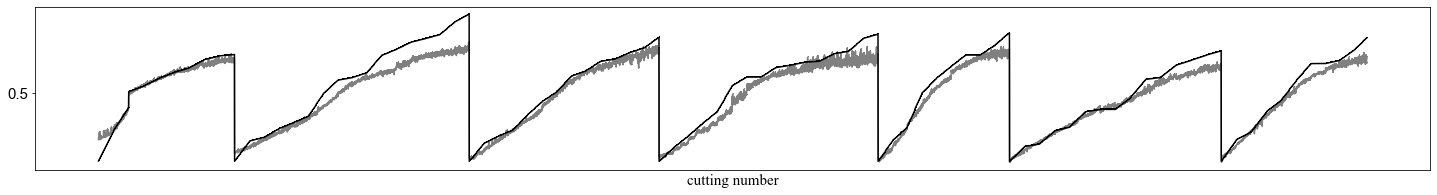

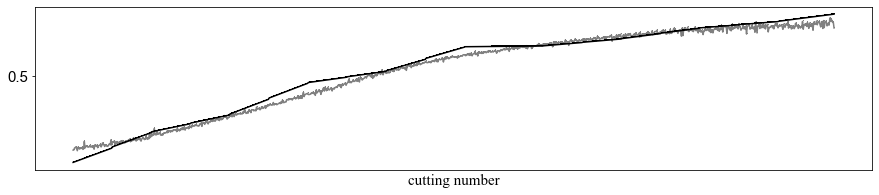

In [4]:
#
import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time

file_index = 2
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径

DOCUMENT_RESULT_PATH = 'results/comparation/loss function/'+str(file_index)+'/'
MODEL_LOAD_PATH = DOCUMENT_RESULT_PATH + 'without_model.h5'
PHYSICINFOMED_SAVEPATH = DOCUMENT_RESULT_PATH + 'without_result.npy'
    
load_flag = 1 ########################################1:重新加载模型，0：不加载##########################

if load_flag == 1:
    #信号层级关系
    SIGNAL_LENGTH_1 = 1536
    SIGNAL_LENGTH_2 = 64
    SIGNAL_LENGTH_3 = 8

    #输入数据
    INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
    INPUT_NUM = INPUT_SIZE[1]
    SCALE_NUM_FORCE = 3 #小波分解级数
    WAVELET_HIGHFREQ = 'db2'
    WAVELET_LOWFREQ = 'db6'
    # NOISE_FILTER_PERCENT = 90
    ATTENTION_RANGE = 24
    WEAR_SIZE = 1
    LIFE_SIZE = 1
    BATCH_SIZE = 64

    def wavelet_transform(data, scale_num):
        coeffs = np.arange(2).tolist()
        for j in range(np.shape(data)[2]):
            sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
            coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
            coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
            coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
            coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
    #         for i in range(1, scale_num+1):       #高频去噪
    #             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
            coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

            if j == 0:
                coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
                coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
            else:
                coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
                coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
        return coeffs

    class lowhigh_freq_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(lowhigh_freq_Attention,self).build(input_shape)
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
            value = x[:, 1:ATTENTION_RANGE+1]
            key = x[:, ATTENTION_RANGE+1:]
    #         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
            scores = tf.matmul(query, key, transpose_b=True)
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.matmul(distribution, value)
    #         print('value_weighted1', np.shape(value_weighted))
            value_weighted = tf.reduce_sum(value_weighted, axis=1)
    #         print('value_weighted2', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape

    class temporal_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(temporal_Attention,self).build(input_shape)
            self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
    #         print('query', np.shape(query))
    #         print('self.u_query', np.shape(self.u_query))
            key = x[:, 1:]
            scores1 = tf.matmul(query, key, transpose_b=True)
    #         print('scores1', np.shape(scores1))
            scores2 = tf.matmul(self.u_query, key, transpose_b=True)
    #         print('scores2', np.shape(scores2))
            scores = scores1 + scores2
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
    #         print('value_weighted1', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape

    X_train_set=np.load(TRAINDATA_LOADPATH)
    Y_train_set = np.load(TRAINLABEL_LOADPATH)
    Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
    X_test_set=np.load(TESTDATA_LOADPATH)
    Y_test_set = np.load(TESTLABEL_LOADPATH)
    Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

    #validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
    X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
    Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
    PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
    X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
    PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

    coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
    coeffs_lowfreq_train = coeffs_train_force[0]
    coeffs_highfreq_train = coeffs_train_force[1]
    coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
    coeffs_lowfreq_test = coeffs_test_force[0]
    coeffs_highfreq_test = coeffs_test_force[1]  

    ################################################### 模型读取及预测 ##################################################
    predictor = keras.models.load_model(MODEL_LOAD_PATH, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                         'temporal_Attention':temporal_Attention})

################################################### 波形显示 ##################################################
fig_x = 15
fig_y = 6
size = 15
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}

#train
wear_pre_train = predictor.predict([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train], batch_size = BATCH_SIZE)
print('wear_pre_train', np.shape(wear_pre_train))

axis = np.linspace(1, np.shape(wear_pre_train)[0], np.shape(wear_pre_train)[0])
print('percent_train_avg', np.mean(np.abs(wear_pre_train[:, 0] - Y_train)/Y_train)*100, '%')
plt.figure(figsize=(25, 3))
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_train[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_train, marker = ',', color = 'black')

#test
# score = predictor.evaluate([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test], Y_test, verbose=0, batch_size = BATCH_SIZE)
time_start = time.time()
wear_pre_test = predictor.predict([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test], batch_size = BATCH_SIZE)
print('time1 =  ', time.time()-time_start, 'sample_num', np.shape(coeffs_lowfreq_test)[0])

axis = np.linspace(1, np.shape(wear_pre_test)[0], np.shape(wear_pre_test)[0])
print('mAPE', np.mean(np.abs((wear_pre_test[:, 0] - Y_test)/Y_test))*100, '%')
print('mFPE', np.mean(np.abs(wear_pre_test[:, 0] - Y_test)), 'um')
print('MFPE', np.max(np.abs(wear_pre_test[:, 0] - Y_test)), 'um')

plt.figure(figsize=(15, 3))
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_test[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_test, marker = ',', color = 'black')

np.save(PHYSICINFOMED_SAVEPATH, wear_pre_test[:, 0])

## phywear

In [4]:
# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB
# LSTM + local attention + global attention
# train_data1， train_label1， test_data1， test_label1， physicsinformed1_model， physicsinformed1_model2表示physics-label one-hot

import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time
%load_ext tensorboard

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

file_index = 2
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径
SUMMARY_PATH = 'logs'     #记录路径

DOCUMENT_RESULT_PATH = 'results/comparation/loss function/'+str(file_index)+'/'
MODEL_SAVE_PATH = DOCUMENT_RESULT_PATH + 'phywear_model.h5'

#信号层级关系
SIGNAL_LENGTH_1 = 1536
SIGNAL_LENGTH_2 = 64
SIGNAL_LENGTH_3 = 8

#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

LOWFREQ_INPUT_SIZE = [int(SIGNAL_LENGTH_1/8), 3]
LOWFREQ_LSTM_SIZE = 13
LOWFREQ_FEATURE_SIZE = 15
ATTENTION_SIZE = 18

HIGHFREQ_INPUT_SIZE = [SIGNAL_LENGTH_1, 3]
HIGHFREQ_LSTM_SIZE = 15
# LOWFREQ_FEATURE_SIZE = ATTENTION_SIZE
ATTENTION_RANGE = 24
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
SAMPLING_STEP = LOWFREQ_INPUT_SIZE[0]//SIGNAL_LENGTH_2

PHYSICS_INPUT_SIZE =6 #输入local的物理条件[拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
PHYSICS_CONCATE1_SIZE = 18 #作为query的输入，包括物理条件和信号的均值和方差
LOCAL_INPUT_SIZE = [SIGNAL_LENGTH_2, LOWFREQ_FEATURE_SIZE+ATTENTION_SIZE]
LOCAL_TIMESTEP = SIGNAL_LENGTH_2//SIGNAL_LENGTH_3

LOCAL_DENSE_SIZE = 25
LOCAL_QUERY_SIZE = LOCAL_DENSE_SIZE

GLOBAL_INPUT_SIZE = [SIGNAL_LENGTH_3, LOCAL_DENSE_SIZE]
GLOBAL_LSTM_SIZE = 25
GLOBAL_DENSE_SIZE = 36
GLOBAL_QUERY_SIZE = GLOBAL_DENSE_SIZE

PHYSICS_RESHAPE_SIZE = [6, 6]
PHYSICS_ATT_SIZE = 20
WEAR_DENSE_SIZE = 100
WEAR_SIZE = 1
LIFE_DENSE_SIZE = 60
LIFE_SIZE = 1

BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH = 6

learning_rate = np.array([1, 0.3, 0.1, 0.8, 0.27, 0.1, 
                 0.64, 0.24, 0.1, 0.51, 0.22, 0.1,
                 0.41, 0.20, 0.1, 0.33, 0.18, 0.1,
                 0.26, 0.16, 0.1])*0.01

weight_rate = np.array([0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 
                        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    
######################################################## 数据集构建 #######################################################################
# X_train [样本总量，样本长度，信号维度]
# Y_train [磨损标签，拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
X_train_set=np.load(TRAINDATA_LOADPATH)
Y_train_set = np.load(TRAINLABEL_LOADPATH)
Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
X_test_set=np.load(TESTDATA_LOADPATH)
Y_test_set = np.load(TESTLABEL_LOADPATH)
Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
# PHY_train[:, -1] = 0.9 - PHY_train[:, -1]*0.8

X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
# PHY_test[:, -1] = 0.9 - PHY_test[:, -1]*0.8

print('X_train', np.shape(X_train), np.min(X_train), np.max(X_train))
print('PHY_train', np.shape(PHY_train), np.min(PHY_train, axis=0), np.max(PHY_train, axis=0))
print('Y_train', np.shape(Y_train), np.min(Y_train), np.max(Y_train))
print('X_test', np.shape(X_test))
print('PHY_test', np.shape(PHY_test))
print('Y_test', np.shape(Y_test))

################################################ 小波分析 ####################################################################################
def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
coeffs_lowfreq_train = coeffs_train_force[0]
coeffs_highfreq_train = coeffs_train_force[1]
print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train), np.min(coeffs_lowfreq_train), np.max(coeffs_lowfreq_train))
print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train), np.min(coeffs_highfreq_train), np.max(coeffs_highfreq_train))

coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
coeffs_lowfreq_test = coeffs_test_force[0]
coeffs_highfreq_test = coeffs_test_force[1]
print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test), np.min(coeffs_lowfreq_test), np.max(coeffs_lowfreq_test))
print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test), np.min(coeffs_highfreq_test), np.max(coeffs_highfreq_test))

######################################################### 模型搭建 ##################################################################
def mean_input_layer(x):#将输入的均值与预测器的特征拼接
    y = backend.mean(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y
def var_input_layer(x):#将输入的方差与预测器的特征拼接
    y = backend.var(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y

def lowfreq_model_construct(input_size, rnn_size, output_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='lowfreq_inputs')
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)
    x = layers.Lambda(lambda x: x[:, ::ATTENTION_RANGE//8])(x)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
    outputs = layers.TimeDistributed(layers.Dense(output_size))(x)
    outputs = layers.BatchNormalization(trainable=False)(outputs)
#     outputs = layers.BatchNormalization()(outputs)
    outputs = layers.LeakyReLU()(outputs)
    query = layers.TimeDistributed(layers.Dense(attention_size))(x)
    query = layers.LayerNormalization(axis = 1)(query)
    query = layers.LeakyReLU()(query)
    model_lowfreq = models.Model(inputs=inputs, outputs=[outputs, query], name = name)
    return model_lowfreq

def highfreq_model_construct(input_size, rnn_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='highfreq_inputs')
#     x = layers.Lambda(adjust_range, name = 'adjust_range')(inputs)
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)#, recurrent_regularizer=regularizers.l1(0.000001)
    key = layers.TimeDistributed(layers.Dense(attention_size))(x)
    key = layers.LayerNormalization(axis = 1)(key)
    key = layers.LeakyReLU()(key)
    value = layers.TimeDistributed(layers.Dense(attention_size))(x)
    value = layers.LayerNormalization(axis = 1)(value)
    value = layers.LeakyReLU()(value)
    model_highfreq = models.Model(inputs=inputs, outputs=[key, value], name = name)
    return model_highfreq

class lowhigh_freq_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
#         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
        scores = tf.matmul(query, key, transpose_b=True)
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.matmul(distribution, value)
#         print('value_weighted1', np.shape(value_weighted))
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
#         print('value_weighted2', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape
    
class temporal_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(temporal_Attention,self).build(input_shape)
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
#         print('query', np.shape(query))
#         print('self.u_query', np.shape(self.u_query))
        key = x[:, 1:]
        scores1 = tf.matmul(query, key, transpose_b=True)
#         print('scores1', np.shape(scores1))
        scores2 = tf.matmul(self.u_query, key, transpose_b=True)
#         print('scores2', np.shape(scores2))
        scores = scores1 + scores2
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
#         print('value_weighted1', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape
    
def localLSTM_construct(input_size, physics_size, timestep, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    inputs_query = layers.Input(shape=physics_size, batch_size = BATCH_SIZE, name='inputs_query')
    query = layers.Dense(dense_size)(inputs_query)
    query = layers.LeakyReLU()(query)
    query = layers.Reshape([1, 1, dense_size])(query)
    query = layers.Concatenate(axis = 1)([query, query, query, query, query, query, query, query])
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.Reshape([int(input_size[0]/timestep), timestep, dense_size])(x)
    x = layers.LayerNormalization(axis = 2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Concatenate(axis = 2)([query, x])
    outputs, att_distribution_local = layers.TimeDistributed(temporal_Attention())(x)
    biLSTM_model = models.Model(inputs=[inputs, inputs_query], outputs=[outputs, att_distribution_local], name = name)
    return biLSTM_model

def globalLSTM_construct(input_size, physics_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    inputs_query = layers.Input(shape=physics_size, batch_size = BATCH_SIZE, name='inputs_query')
    query = layers.Dense(dense_size)(inputs_query)
    query = layers.LeakyReLU()(query)
    query = layers.Reshape([1, dense_size])(query)
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.LayerNormalization(axis = 1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Concatenate(axis = 1)([query, x])
    outputs, att_distribution_global = temporal_Attention()(x)
    biLSTM_model = models.Model(inputs=[inputs, inputs_query], outputs=[outputs, att_distribution_global], name = name)
    return biLSTM_model

def multiply_construct(input_feature_size, feature_reshape_size, input_physics_size, dense_att_size, name):
    inputs_feature = layers.Input(shape=input_feature_size, batch_size = BATCH_SIZE, name='inputs_feature')
    feature = layers.Reshape(feature_reshape_size)(inputs_feature)
    feature = layers.TimeDistributed(layers.Dense(dense_att_size, activation = 'tanh'))(feature)
    inputs_physics = layers.Input(shape=input_physics_size, batch_size = BATCH_SIZE, name='inputs_physics')
    physics = layers.Dense(dense_att_size, activation = 'tanh')(inputs_physics)
    physics = layers.Reshape([1, dense_att_size])(physics)
    outputs = layers.Attention(use_scale=False)([physics, feature])
    outputs = layers.Reshape([dense_att_size])(outputs)
    multiply_model = models.Model(inputs=[inputs_feature, inputs_physics], outputs=outputs, name = name)
    return multiply_model

#这里将物理模型的输出与信号的平均值和方差作为提示特征
#低频
input_lowfreq = layers.Input(shape=LOWFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_lowfreq')
mean_lowfreq = layers.Lambda(mean_input_layer, name = 'mean_lowfreq')(input_lowfreq)
var_lowfreq = layers.Lambda(var_input_layer, name = 'var_lowfreq')(input_lowfreq)
# input_lowfreq1 = layers.BatchNormalization()(input_lowfreq)
input_lowfreq1 = layers.BatchNormalization(trainable=False)(input_lowfreq)
#高频
input_highfreq = layers.Input(shape=HIGHFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_highfreq')
mean_highfreq = layers.Lambda(mean_input_layer, name = 'mean_highfreq')(input_highfreq)
var_highfreq = layers.Lambda(var_input_layer, name = 'var_highfreq')(input_highfreq)
input_highfreq1 = layers.BatchNormalization(trainable=False)(input_highfreq)
# input_highfreq1 = layers.BatchNormalization()(input_highfreq)
#提示特征
input_physics = layers.Input(shape=PHYSICS_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_physics')
print('mean_lowfreq', np.shape(mean_lowfreq), 'mean_highfreq', np.shape(mean_highfreq), 'input_physics', np.shape(input_physics))
input_physics1 = layers.Concatenate(axis = 1)([mean_lowfreq, var_lowfreq, mean_highfreq, var_highfreq, input_physics])#提示特征
# print('input_physics1', np.shape(input_physics1))

model_lowfreq = lowfreq_model_construct(LOWFREQ_INPUT_SIZE, LOWFREQ_LSTM_SIZE, LOWFREQ_FEATURE_SIZE, ATTENTION_SIZE, 'lowfreq_model')
model_highfreq = highfreq_model_construct(HIGHFREQ_INPUT_SIZE, HIGHFREQ_LSTM_SIZE, ATTENTION_SIZE, 'highfreq_model')
# 低频特征构造query，高频特征构造key和value，构建低频特征向高频特征的注意力模型，使高低频长度一致并对齐
feature_lowfreq, query = model_lowfreq(input_lowfreq1)
# feature_lowfreq = layers.Lambda(lambda x: x[:, ::6])(feature_lowfreq)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
# query = layers.Lambda(lambda x: x[:, ::6])(query)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
key, value = model_highfreq(input_highfreq1)

#高低频注意力机制
query = layers.Reshape([-1, 1, ATTENTION_SIZE])(query)
value = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(value)
key = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(key)
concate_vector = layers.Concatenate(axis = 2)([query, value, key])
feature_highfreq, att_distribution_lowhigh = layers.TimeDistributed(lowhigh_freq_Attention())(concate_vector)
# feature_highfreq = layers.BatchNormalization()(feature_highfreq)
feature_highfreq = layers.BatchNormalization(trainable=False)(feature_highfreq)
feature_freq = layers.Concatenate(axis = 2)([feature_lowfreq, feature_highfreq])
print('feature_freq', np.shape(feature_freq))

#local attention
biLSTM_local = localLSTM_construct(LOCAL_INPUT_SIZE, PHYSICS_CONCATE1_SIZE, LOCAL_TIMESTEP, LOCAL_DENSE_SIZE, 'biLSTM_local')
feature_local, att_distribution_local = biLSTM_local([feature_freq, input_physics1])
feature_local = layers.BatchNormalization(trainable=False)(feature_local)
# feature_local = layers.BatchNormalization()(feature_local)
print('feature_local', feature_local)

#global attention
biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, PHYSICS_CONCATE1_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
# biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_LSTM_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
feature, att_distribution_global = biLSTM_global([feature_local, input_physics1])
print('feature', np.shape(feature))

#physics dense
multiply_physics = multiply_construct(GLOBAL_DENSE_SIZE, PHYSICS_RESHAPE_SIZE, PHYSICS_INPUT_SIZE, PHYSICS_ATT_SIZE, 'physics')
physics_feature = multiply_physics([feature, input_physics])
physics_feature = layers.Reshape([PHYSICS_ATT_SIZE])(physics_feature)
print('physics_feature', np.shape(physics_feature))

#tool wear predict
x = layers.Dense(WEAR_DENSE_SIZE)(physics_feature)
x = layers.BatchNormalization(trainable=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
wear_predict = layers.Dense(WEAR_SIZE, activation = 'sigmoid', name='wear_predict')(x)

#remaining life predict
x = layers.Dense(LIFE_DENSE_SIZE)(physics_feature)
x = layers.BatchNormalization(trainable=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
life_predict = layers.Dense(LIFE_SIZE, activation = 'sigmoid', name='life_predict')(x)

predictor = models.Model(inputs=[input_lowfreq, input_highfreq, input_physics], 
                         outputs=[wear_predict, life_predict], name='tool_wear_predictor')
predictor.summary()

#############################################模型训练#########################################################################
time_start = time.time()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=SUMMARY_PATH, histogram_freq=1)
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_mape',  save_best_only=True, mode='auto')

for i in range(PREDICTOR_TRAIN_BATCH):
    print('##########'+str(i+1)+'############')
    adam = keras.optimizers.Adam(lr=learning_rate[i])
    predictor.compile(optimizer=adam, loss = 'mse', loss_weights={'wear_predict':1., 'life_predict':weight_rate[i]})
    history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train[:, 1:]], [Y_train, PHY_train[:, 0]], batch_size=BATCH_SIZE, 
                            validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test[:, 1:]], [Y_test, PHY_test[:, 0]]), 
                            epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])
    
# predictor.save(MODEL_SAVE_PATH)
print('time1 =  ', time.time()-time_start)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
X_train (9728, 1536, 3) -1.0226240158081055 0.8822135925292969
PHY_train (9728, 7) [1.8072429e-01 6.0000002e-01 6.0000002e-01 3.3333334e-01 2.0000000e-01
 2.0000000e-01 3.8910506e-04] [0.863643   1.         1.         1.         1.         1.
 0.99833196]
Y_train (9728,) 0.18163076 0.87186223
X_test (1088, 1536, 3)
PHY_test (1088, 7)
Y_test (1088,)
coeffs_lowfreq_train (9728, 192, 3) -1.6887109675302232 1.6827855264342724
coeffs_highfreq_train (9728, 1536, 3) -0.8882813551840282 0.7132884507306377
coeffs_lowfreq_test (1088, 192, 3) -1.568536880631073 1.5703575546262813
coeffs_highfreq_test (1088, 1536, 3) -0.5007195881400437 0.5713501438158957
mean_lowfreq (64, 3) mean_highfreq (64, 3) input_physics (64, 6)
feature_freq (64, 64, 33)
feature_local KerasTensor(type_spec=TensorSpec(shape=(64, 8, 25), dtype=tf.float32, name=None), name='batch_normalization_4/batchnorm/add_1:0', description="created by

152/152 [==============================] - 80s 462ms/step - loss: 0.0116 - wear_predict_loss: 0.0088 - life_predict_loss: 0.0092 - val_loss: 0.0092 - val_wear_predict_loss: 0.0073 - val_life_predict_loss: 0.0064
##########2############
152/152 [==============================] - 86s 490ms/step - loss: 0.0018 - wear_predict_loss: 0.0013 - life_predict_loss: 0.0016 - val_loss: 0.0211 - val_wear_predict_loss: 0.0181 - val_life_predict_loss: 0.0101
##########3############
152/152 [==============================] - 88s 529ms/step - loss: 4.8879e-04 - wear_predict_loss: 3.5883e-04 - life_predict_loss: 4.3321e-04 - val_loss: 0.0232 - val_wear_predict_loss: 0.0201 - val_life_predict_loss: 0.0103
##########4############
152/152 [==============================] - 93s 563ms/step - loss: 0.0055 - wear_predict_loss: 0.0047 - life_predict_loss: 0.0042 - val_loss: 0.0325 - val_wear_predict_loss: 0.0266 - val_life_predict_loss: 0.0294
##########5############
152/152 [==============================] - 9

### 结果输出

wear_pre_train (9728, 1)
life_pre_train (9728, 1)
loss_train_avg 0.00013797657
percent_train_avg 2.074349857866764 %


<Figure size 1080x432 with 0 Axes>

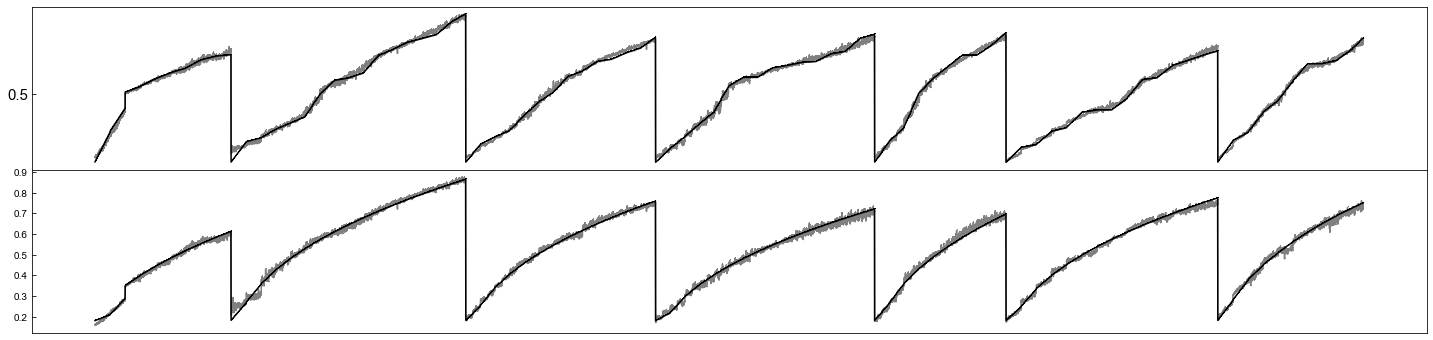

time1 =   2.0965681076049805 sample_num 1088
loss_test_avg 0.021789586
percent_test_avg 28.145432472229004 %


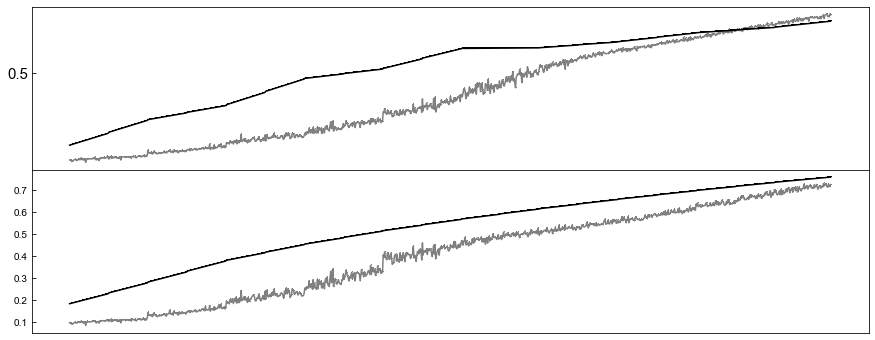

In [5]:
#


import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time

file_index = 2
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径

DOCUMENT_RESULT_PATH = 'results/comparation/loss function/'+str(file_index)+'/'
MODEL_LOAD_PATH = DOCUMENT_RESULT_PATH + 'phywear_model.h5'
PHYSICINFOMED_SAVEPATH = DOCUMENT_RESULT_PATH + 'phywear_result.npy'
    
load_flag = 1 ########################################1:重新加载模型，0：不加载##########################

if load_flag == 1:
    #信号层级关系
    SIGNAL_LENGTH_1 = 1536
    SIGNAL_LENGTH_2 = 64
    SIGNAL_LENGTH_3 = 8

    #输入数据
    INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
    INPUT_NUM = INPUT_SIZE[1]
    SCALE_NUM_FORCE = 3 #小波分解级数
    WAVELET_HIGHFREQ = 'db2'
    WAVELET_LOWFREQ = 'db6'
    # NOISE_FILTER_PERCENT = 90
    ATTENTION_RANGE = 24
    WEAR_SIZE = 1
    LIFE_SIZE = 1
    BATCH_SIZE = 64

    def wavelet_transform(data, scale_num):
        coeffs = np.arange(2).tolist()
        for j in range(np.shape(data)[2]):
            sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
            coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
            coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
            coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
            coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
    #         for i in range(1, scale_num+1):       #高频去噪
    #             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
            coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

            if j == 0:
                coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
                coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
            else:
                coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
                coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
        return coeffs

    class lowhigh_freq_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(lowhigh_freq_Attention,self).build(input_shape)
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
            value = x[:, 1:ATTENTION_RANGE+1]
            key = x[:, ATTENTION_RANGE+1:]
    #         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
            scores = tf.matmul(query, key, transpose_b=True)
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.matmul(distribution, value)
    #         print('value_weighted1', np.shape(value_weighted))
            value_weighted = tf.reduce_sum(value_weighted, axis=1)
    #         print('value_weighted2', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape
    
    class temporal_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(temporal_Attention,self).build(input_shape)
            self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
    #         print('query', np.shape(query))
    #         print('self.u_query', np.shape(self.u_query))
            key = x[:, 1:]
            scores1 = tf.matmul(query, key, transpose_b=True)
    #         print('scores1', np.shape(scores1))
            scores2 = tf.matmul(self.u_query, key, transpose_b=True)
    #         print('scores2', np.shape(scores2))
            scores = scores1 + scores2
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
    #         print('value_weighted1', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape

    X_train_set=np.load(TRAINDATA_LOADPATH)
    Y_train_set = np.load(TRAINLABEL_LOADPATH)
    Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
    X_test_set=np.load(TESTDATA_LOADPATH)
    Y_test_set = np.load(TESTLABEL_LOADPATH)
    Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

    X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
    Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
    PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
#     PHY_train[:, -1] = 0.9 - PHY_train[:, -1]*0.8

    X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
    PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
#     PHY_test[:, -1] = 0.9 - PHY_test[:, -1]*0.8

    coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
    coeffs_lowfreq_train = coeffs_train_force[0]
    coeffs_highfreq_train = coeffs_train_force[1]
    coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
    coeffs_lowfreq_test = coeffs_test_force[0]
    coeffs_highfreq_test = coeffs_test_force[1]  

    ################################################### 模型读取及预测 ##################################################
    predictor = keras.models.load_model(MODEL_LOAD_PATH, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                         'temporal_Attention':temporal_Attention})

################################################### 波形显示 ##################################################
fig_x = 15
fig_y = 6
size = 15
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}

#train
wear_pre_train, life_pre_train = predictor.predict([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train[:, 1:]], batch_size = BATCH_SIZE)
print('wear_pre_train', np.shape(wear_pre_train))
print('life_pre_train', np.shape(life_pre_train))

axis = np.linspace(1, np.shape(wear_pre_train)[0], np.shape(wear_pre_train)[0])
print('loss_train_avg', np.mean(np.square(wear_pre_train[:, 0] - Y_train)))
print('percent_train_avg', np.mean(np.abs(wear_pre_train[:, 0] - Y_train)/Y_train)*100, '%')
plt.figure(figsize=(25, 6))
plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(2,1,1)
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_train[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_train, marker = ',', color = 'black')
plt.subplot(2,1,2)
plt.xticks([])  #去掉纵坐标值
plt.plot(axis, life_pre_train[:, 0], marker = ',', color = 'gray')
plt.plot(axis, PHY_train[:, 0], marker = ',', color = 'black')
plt.show()

#test
# score = predictor.evaluate([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test], Y_test, verbose=0, batch_size = BATCH_SIZE)
time_start = time.time()
wear_pre_test, life_pre_test = predictor.predict([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test[:, 1:]], batch_size = BATCH_SIZE)
print('time1 =  ', time.time()-time_start, 'sample_num', np.shape(coeffs_lowfreq_test)[0])

axis = np.linspace(1, np.shape(wear_pre_test)[0], np.shape(wear_pre_test)[0])
print('loss_test_avg', np.mean(np.square(wear_pre_test[:, 0] - Y_test)))
print('percent_test_avg', np.mean(np.abs(wear_pre_test[:, 0] - Y_test)/Y_test)*100, '%')
plt.figure(figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(2,1,1)
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_test[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_test, marker = ',', color = 'black')
plt.subplot(2,1,2)
plt.xticks([])  #去掉纵坐标值
plt.plot(axis, life_pre_test[:, 0], marker = ',', color = 'gray')
plt.plot(axis, PHY_test[:, 0], marker = ',', color = 'black')
# plt.savefig(DOCUMENT_RESULT_PATH + 'test_output.eps')
plt.show()

np.save(PHYSICINFOMED_SAVEPATH, wear_pre_test[:, 0])

# 4.397   5.277   5.46  4.53  5.558
# 4.495   4.719   5.017  4.992
# 2.582   3.926

## life_phywear

In [1]:
# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB
# LSTM + local attention + global attention
# train_data1， train_label1， test_data1， test_label1， physicsinformed1_model， physicsinformed1_model2表示physics-label one-hot

import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time
%load_ext tensorboard

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

file_index = 8
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径
SUMMARY_PATH = 'logs'     #记录路径

DOCUMENT_RESULT_PATH = 'results/comparation/loss function/'+str(file_index)+'/'
MODEL_SAVE_PATH = DOCUMENT_RESULT_PATH + 'life_phywear.h5'

#信号层级关系
SIGNAL_LENGTH_1 = 1536
SIGNAL_LENGTH_2 = 64
SIGNAL_LENGTH_3 = 8

#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

LOWFREQ_INPUT_SIZE = [int(SIGNAL_LENGTH_1/8), 3]
LOWFREQ_LSTM_SIZE = 13
LOWFREQ_FEATURE_SIZE = 15
ATTENTION_SIZE = 18

HIGHFREQ_INPUT_SIZE = [SIGNAL_LENGTH_1, 3]
HIGHFREQ_LSTM_SIZE = 15
# LOWFREQ_FEATURE_SIZE = ATTENTION_SIZE
ATTENTION_RANGE = 24
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
SAMPLING_STEP = LOWFREQ_INPUT_SIZE[0]//SIGNAL_LENGTH_2

PHYSICS_INPUT_SIZE =5 #输入local的物理条件[拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
PHYSICS_CONCATE1_SIZE = 17 #作为query的输入，包括物理条件和信号的均值和方差
LOCAL_INPUT_SIZE = [SIGNAL_LENGTH_2, LOWFREQ_FEATURE_SIZE+ATTENTION_SIZE]
LOCAL_TIMESTEP = SIGNAL_LENGTH_2//SIGNAL_LENGTH_3

LOCAL_DENSE_SIZE = 25
LOCAL_QUERY_SIZE = LOCAL_DENSE_SIZE

GLOBAL_INPUT_SIZE = [SIGNAL_LENGTH_3, LOCAL_DENSE_SIZE]
GLOBAL_LSTM_SIZE = 25
GLOBAL_DENSE_SIZE = 36
GLOBAL_QUERY_SIZE = GLOBAL_DENSE_SIZE

PHYSICS_RESHAPE_SIZE = [6, 6]
PHYSICS_ATT_SIZE = 20
WEAR_DENSE_SIZE = 150
WEAR_SIZE = 1
LIFE_DENSE_SIZE = 80
LIFE_SIZE = 2

BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH = 9

learning_rate = np.array([1, 0.3, 0.1, 0.8, 0.27, 0.1, 
                 0.64, 0.24, 0.1, 0.51, 0.22, 0.1,
                 0.41, 0.20, 0.1, 0.33, 0.18, 0.1,
                 0.26, 0.16, 0.1])*0.01

weight_rate = np.array([0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 
                        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    
######################################################## 数据集构建 #######################################################################
# X_train [样本总量，样本长度，信号维度]
# Y_train [磨损标签，拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
X_train_set=np.load(TRAINDATA_LOADPATH)
Y_train_set = np.load(TRAINLABEL_LOADPATH)
Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
X_test_set=np.load(TESTDATA_LOADPATH)
Y_test_set = np.load(TESTLABEL_LOADPATH)
Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

print('X_train', np.shape(X_train), np.min(X_train), np.max(X_train))
print('PHY_train', np.shape(PHY_train), np.min(PHY_train, axis=0), np.max(PHY_train, axis=0))
print('Y_train', np.shape(Y_train), np.min(Y_train), np.max(Y_train))
print('X_test', np.shape(X_test))
print('PHY_test', np.shape(PHY_test))
print('Y_test', np.shape(Y_test))

################################################ 小波分析 ####################################################################################
def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
coeffs_lowfreq_train = coeffs_train_force[0]
coeffs_highfreq_train = coeffs_train_force[1]
print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train), np.min(coeffs_lowfreq_train), np.max(coeffs_lowfreq_train))
print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train), np.min(coeffs_highfreq_train), np.max(coeffs_highfreq_train))

coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
coeffs_lowfreq_test = coeffs_test_force[0]
coeffs_highfreq_test = coeffs_test_force[1]
print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test), np.min(coeffs_lowfreq_test), np.max(coeffs_lowfreq_test))
print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test), np.min(coeffs_highfreq_test), np.max(coeffs_highfreq_test))

######################################################### 模型搭建 ##################################################################
def mean_input_layer(x):#将输入的均值与预测器的特征拼接
    y = backend.mean(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y
def var_input_layer(x):#将输入的方差与预测器的特征拼接
    y = backend.var(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y

def lowfreq_model_construct(input_size, rnn_size, output_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='lowfreq_inputs')
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)
    x = layers.Lambda(lambda x: x[:, ::ATTENTION_RANGE//8])(x)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
    outputs = layers.TimeDistributed(layers.Dense(output_size))(x)
    outputs = layers.BatchNormalization(trainable=False)(outputs)
#     outputs = layers.BatchNormalization()(outputs)
    outputs = layers.LeakyReLU()(outputs)
    query = layers.TimeDistributed(layers.Dense(attention_size))(x)
    query = layers.LayerNormalization(axis = 1)(query)
    query = layers.LeakyReLU()(query)
    model_lowfreq = models.Model(inputs=inputs, outputs=[outputs, query], name = name)
    return model_lowfreq

def highfreq_model_construct(input_size, rnn_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='highfreq_inputs')
#     x = layers.Lambda(adjust_range, name = 'adjust_range')(inputs)
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)#, recurrent_regularizer=regularizers.l1(0.000001)
    key = layers.TimeDistributed(layers.Dense(attention_size))(x)
    key = layers.LayerNormalization(axis = 1)(key)
    key = layers.LeakyReLU()(key)
    value = layers.TimeDistributed(layers.Dense(attention_size))(x)
    value = layers.LayerNormalization(axis = 1)(value)
    value = layers.LeakyReLU()(value)
    model_highfreq = models.Model(inputs=inputs, outputs=[key, value], name = name)
    return model_highfreq

class lowhigh_freq_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
#         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
        scores = tf.matmul(query, key, transpose_b=True)
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.matmul(distribution, value)
#         print('value_weighted1', np.shape(value_weighted))
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
#         print('value_weighted2', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape
    
class temporal_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(temporal_Attention,self).build(input_shape)
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
#         print('query', np.shape(query))
#         print('self.u_query', np.shape(self.u_query))
        key = x[:, 1:]
        scores1 = tf.matmul(query, key, transpose_b=True)
#         print('scores1', np.shape(scores1))
        scores2 = tf.matmul(self.u_query, key, transpose_b=True)
#         print('scores2', np.shape(scores2))
        scores = scores1 + scores2
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
#         print('value_weighted1', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape
    
def localLSTM_construct(input_size, physics_size, timestep, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    inputs_query = layers.Input(shape=physics_size, batch_size = BATCH_SIZE, name='inputs_query')
    query = layers.Dense(dense_size)(inputs_query)
    query = layers.LeakyReLU()(query)
    query = layers.Reshape([1, 1, dense_size])(query)
    query = layers.Concatenate(axis = 1)([query, query, query, query, query, query, query, query])
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.Reshape([int(input_size[0]/timestep), timestep, dense_size])(x)
    x = layers.LayerNormalization(axis = 2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Concatenate(axis = 2)([query, x])
    outputs, att_distribution_local = layers.TimeDistributed(temporal_Attention())(x)
    biLSTM_model = models.Model(inputs=[inputs, inputs_query], outputs=[outputs, att_distribution_local], name = name)
    return biLSTM_model

def globalLSTM_construct(input_size, physics_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    inputs_query = layers.Input(shape=physics_size, batch_size = BATCH_SIZE, name='inputs_query')
    query = layers.Dense(dense_size)(inputs_query)
    query = layers.LeakyReLU()(query)
    query = layers.Reshape([1, dense_size])(query)
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.LayerNormalization(axis = 1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Concatenate(axis = 1)([query, x])
    outputs, att_distribution_global = temporal_Attention()(x)
    biLSTM_model = models.Model(inputs=[inputs, inputs_query], outputs=[outputs, att_distribution_global], name = name)
    return biLSTM_model

def multiply_construct(input_feature_size, feature_reshape_size, input_physics_size, dense_att_size, name):
    inputs_feature = layers.Input(shape=input_feature_size, batch_size = BATCH_SIZE, name='inputs_feature')
    feature = layers.Reshape(feature_reshape_size)(inputs_feature)
    feature = layers.TimeDistributed(layers.Dense(dense_att_size, activation = 'tanh'))(feature)
    inputs_physics = layers.Input(shape=input_physics_size, batch_size = BATCH_SIZE, name='inputs_physics')
    physics = layers.Dense(dense_att_size, activation = 'tanh')(inputs_physics)
    physics = layers.Reshape([1, dense_att_size])(physics)
    outputs = layers.Attention(use_scale=False)([physics, feature])
    outputs = layers.Reshape([dense_att_size])(outputs)
    multiply_model = models.Model(inputs=[inputs_feature, inputs_physics], outputs=outputs, name = name)
    return multiply_model

#这里将物理模型的输出与信号的平均值和方差作为提示特征
#低频
input_lowfreq = layers.Input(shape=LOWFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_lowfreq')
mean_lowfreq = layers.Lambda(mean_input_layer, name = 'mean_lowfreq')(input_lowfreq)
var_lowfreq = layers.Lambda(var_input_layer, name = 'var_lowfreq')(input_lowfreq)
# input_lowfreq1 = layers.BatchNormalization()(input_lowfreq)
input_lowfreq1 = layers.BatchNormalization(trainable=False)(input_lowfreq)
#高频
input_highfreq = layers.Input(shape=HIGHFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_highfreq')
mean_highfreq = layers.Lambda(mean_input_layer, name = 'mean_highfreq')(input_highfreq)
var_highfreq = layers.Lambda(var_input_layer, name = 'var_highfreq')(input_highfreq)
input_highfreq1 = layers.BatchNormalization(trainable=False)(input_highfreq)
# input_highfreq1 = layers.BatchNormalization()(input_highfreq)
#提示特征
input_physics = layers.Input(shape=PHYSICS_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_physics')
print('mean_lowfreq', np.shape(mean_lowfreq), 'mean_highfreq', np.shape(mean_highfreq), 'input_physics', np.shape(input_physics))
input_physics1 = layers.Concatenate(axis = 1)([mean_lowfreq, var_lowfreq, mean_highfreq, var_highfreq, input_physics])#提示特征
# print('input_physics1', np.shape(input_physics1))

model_lowfreq = lowfreq_model_construct(LOWFREQ_INPUT_SIZE, LOWFREQ_LSTM_SIZE, LOWFREQ_FEATURE_SIZE, ATTENTION_SIZE, 'lowfreq_model')
model_highfreq = highfreq_model_construct(HIGHFREQ_INPUT_SIZE, HIGHFREQ_LSTM_SIZE, ATTENTION_SIZE, 'highfreq_model')
# 低频特征构造query，高频特征构造key和value，构建低频特征向高频特征的注意力模型，使高低频长度一致并对齐
feature_lowfreq, query = model_lowfreq(input_lowfreq1)
# feature_lowfreq = layers.Lambda(lambda x: x[:, ::6])(feature_lowfreq)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
# query = layers.Lambda(lambda x: x[:, ::6])(query)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
key, value = model_highfreq(input_highfreq1)

#高低频注意力机制
query = layers.Reshape([-1, 1, ATTENTION_SIZE])(query)
value = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(value)
key = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(key)
concate_vector = layers.Concatenate(axis = 2)([query, value, key])
feature_highfreq, att_distribution_lowhigh = layers.TimeDistributed(lowhigh_freq_Attention())(concate_vector)
# feature_highfreq = layers.BatchNormalization()(feature_highfreq)
feature_highfreq = layers.BatchNormalization(trainable=False)(feature_highfreq)
feature_freq = layers.Concatenate(axis = 2)([feature_lowfreq, feature_highfreq])
print('feature_freq', np.shape(feature_freq))

#local attention
biLSTM_local = localLSTM_construct(LOCAL_INPUT_SIZE, PHYSICS_CONCATE1_SIZE, LOCAL_TIMESTEP, LOCAL_DENSE_SIZE, 'biLSTM_local')
feature_local, att_distribution_local = biLSTM_local([feature_freq, input_physics1])
feature_local = layers.BatchNormalization(trainable=False)(feature_local)
# feature_local = layers.BatchNormalization()(feature_local)
print('feature_local', feature_local)

#global attention
biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, PHYSICS_CONCATE1_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
# biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_LSTM_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
feature, att_distribution_global = biLSTM_global([feature_local, input_physics1])
print('feature', np.shape(feature))

#physics dense
multiply_physics = multiply_construct(GLOBAL_DENSE_SIZE, PHYSICS_RESHAPE_SIZE, PHYSICS_INPUT_SIZE, PHYSICS_ATT_SIZE, 'physics')
physics_feature = multiply_physics([feature, input_physics])
physics_feature = layers.Reshape([PHYSICS_ATT_SIZE])(physics_feature)
print('physics_feature', np.shape(physics_feature))

#tool wear predict
x = layers.Dense(WEAR_DENSE_SIZE)(physics_feature)
x = layers.BatchNormalization(trainable=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
wear_predict = layers.Dense(WEAR_SIZE, activation = 'sigmoid', name='wear_predict')(x)

#remaining life predict
x = layers.Dense(LIFE_DENSE_SIZE)(physics_feature)
x = layers.BatchNormalization(trainable=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
life_predict = layers.Dense(LIFE_SIZE, activation = 'sigmoid', name='life_predict')(x)

predictor = models.Model(inputs=[input_lowfreq, input_highfreq, input_physics], 
                         outputs=[wear_predict, life_predict], name='tool_wear_predictor')
att_distribution_model = models.Model(inputs=[input_lowfreq, input_highfreq, input_physics], 
                                      outputs=[att_distribution_lowhigh, att_distribution_local], 
                                      name = 'att_distribution_model')
predictor.summary()

print(np.shape(PHY_train[:, 0]))
print(np.shape(np.concatenate([PHY_train[:, 0], PHY_train[:, -1]], axis = -1)))
#############################################模型训练#########################################################################
time_start = time.time()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=SUMMARY_PATH, histogram_freq=1)
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='wear_predict',  save_best_only=True, mode='max')
for i in range(PREDICTOR_TRAIN_BATCH):
    print('##########'+str(i+1)+'############')
    adam = keras.optimizers.Adam(lr=learning_rate[i])
    predictor.compile(optimizer=adam, loss = 'mse', loss_weights={'wear_predict':1., 'life_predict':weight_rate[i]})
    history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train[:, 1:-1]], 
                            [Y_train, [PHY_train[:, 0], PHY_train[:, -1]]], batch_size=BATCH_SIZE, 
                            validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test[:, 1:-1]], 
                                               [Y_test, [PHY_test[:, 0], PHY_test[:, -1]]]), 
                                               epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])
    
predictor.save(MODEL_SAVE_PATH)
print('time1 =  ', time.time()-time_start)

X_train (9728, 1536, 3) -0.9293552041053772 0.8662327527999878
PHY_train (9728, 7) [1.8072429e-01 6.0000002e-01 6.0000002e-01 3.3333334e-01 2.0000000e-01
 2.0000000e-01 3.8910506e-04] [0.863643   1.         1.         1.         1.         1.
 0.99833196]
Y_train (9728,) 0.18163076 0.87186223
X_test (1088, 1536, 3)
PHY_test (1088, 7)
Y_test (1088,)
coeffs_lowfreq_train (9728, 192, 3) -1.6887109675302232 1.6770890508760357
coeffs_highfreq_train (9728, 1536, 3) -0.6074406355435511 0.6436477411157987
coeffs_lowfreq_test (1088, 192, 3) -1.5425268591451757 1.6827855264342724
coeffs_highfreq_test (1088, 1536, 3) -0.8581441584885379 0.6740121754985141
mean_lowfreq (64, 3) mean_highfreq (64, 3) input_physics (64, 5)
feature_freq (64, 64, 33)
feature_local KerasTensor(type_spec=TensorSpec(shape=(64, 8, 25), dtype=tf.float32, name=None), name='batch_normalization_4/batchnorm/add_1:0', description="created by layer 'batch_normalization_4'")
feature (64, 36)
physics_feature (64, 20)
Model: "tool_w

152/152 [==============================] - 75s 443ms/step - loss: 0.0146 - wear_predict_loss: 0.0112 - life_predict_loss: 0.0113 - val_loss: 0.0018 - val_wear_predict_loss: 0.0013 - val_life_predict_loss: 0.0017
##########2############
152/152 [==============================] - 78s 459ms/step - loss: 0.0027 - wear_predict_loss: 0.0019 - life_predict_loss: 0.0025 - val_loss: 0.0017 - val_wear_predict_loss: 0.0012 - val_life_predict_loss: 0.0017
##########3############
152/152 [==============================] - 78s 462ms/step - loss: 0.0016 - wear_predict_loss: 0.0012 - life_predict_loss: 0.0016 - val_loss: 0.0015 - val_wear_predict_loss: 0.0011 - val_life_predict_loss: 0.0015
##########4############
152/152 [==============================] - 79s 465ms/step - loss: 0.0027 - wear_predict_loss: 0.0021 - life_predict_loss: 0.0027 - val_loss: 0.0014 - val_wear_predict_loss: 0.0011 - val_life_predict_loss: 0.0016
##########5############
152/152 [==============================] - 80s 481ms/ste

### 结果显示

wear_pre_train (9728, 1)
life_pre_train (9728, 2)
loss_train_avg 0.00062826986
percent_train_avg 4.28364984691143 %


<Figure size 1080x432 with 0 Axes>

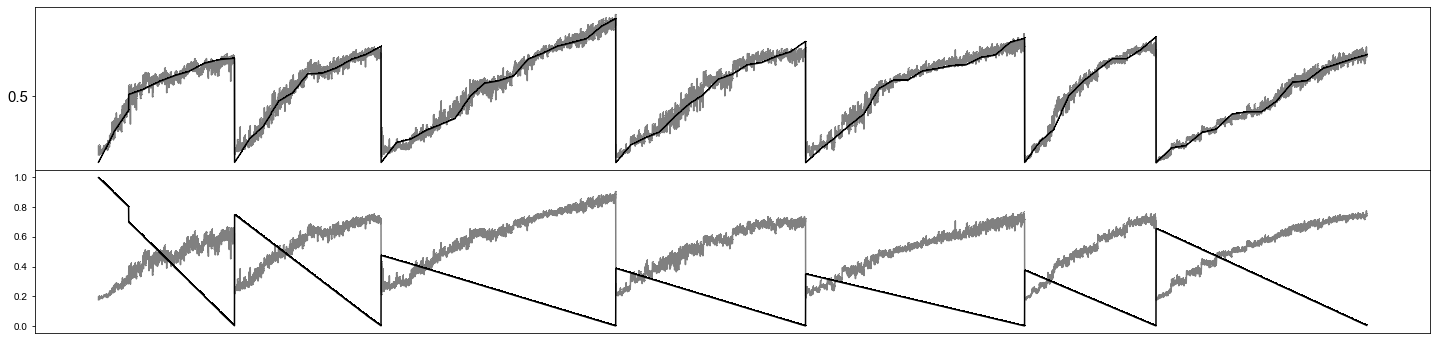

time1 =   3.274618625640869 sample_num 1088
loss_test_avg 0.0015842944
percent_test_avg 6.56292587518692 %


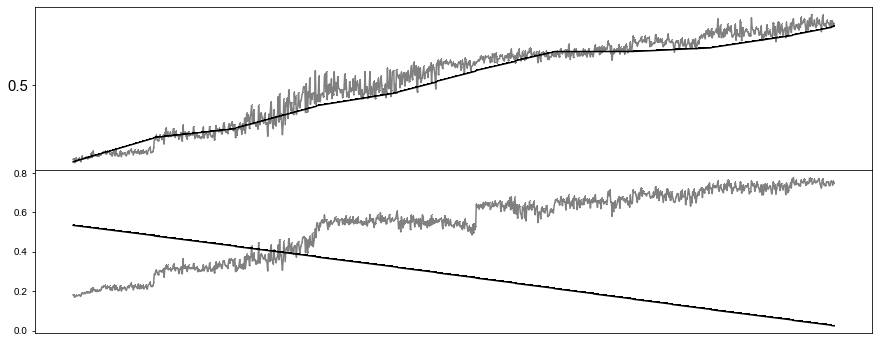

In [1]:
#
import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time

file_index = 8
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径

DOCUMENT_RESULT_PATH = 'results/comparation/loss function/'+str(file_index)+'/'
MODEL_LOAD_PATH = DOCUMENT_RESULT_PATH + 'life_phywear.h5'
PHYSICINFOMED_SAVEPATH = DOCUMENT_RESULT_PATH + 'life_phywear_result.npy'
    
load_flag = 1 ########################################1:重新加载模型，0：不加载##########################

if load_flag == 1:
    #信号层级关系
    SIGNAL_LENGTH_1 = 1536
    SIGNAL_LENGTH_2 = 64
    SIGNAL_LENGTH_3 = 8

    #输入数据
    INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
    INPUT_NUM = INPUT_SIZE[1]
    SCALE_NUM_FORCE = 3 #小波分解级数
    WAVELET_HIGHFREQ = 'db2'
    WAVELET_LOWFREQ = 'db6'
    # NOISE_FILTER_PERCENT = 90
    ATTENTION_RANGE = 24
    WEAR_SIZE = 1
    LIFE_SIZE = 2
    BATCH_SIZE = 64

    def wavelet_transform(data, scale_num):
        coeffs = np.arange(2).tolist()
        for j in range(np.shape(data)[2]):
            sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
            coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
            coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
            coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
            coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
    #         for i in range(1, scale_num+1):       #高频去噪
    #             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
            coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

            if j == 0:
                coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
                coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
            else:
                coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
                coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
        return coeffs

    class lowhigh_freq_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(lowhigh_freq_Attention,self).build(input_shape)
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
            value = x[:, 1:ATTENTION_RANGE+1]
            key = x[:, ATTENTION_RANGE+1:]
    #         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
            scores = tf.matmul(query, key, transpose_b=True)
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.matmul(distribution, value)
    #         print('value_weighted1', np.shape(value_weighted))
            value_weighted = tf.reduce_sum(value_weighted, axis=1)
    #         print('value_weighted2', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape

    class temporal_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(temporal_Attention,self).build(input_shape)
            self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
    #         print('query', np.shape(query))
    #         print('self.u_query', np.shape(self.u_query))
            key = x[:, 1:]
            scores1 = tf.matmul(query, key, transpose_b=True)
    #         print('scores1', np.shape(scores1))
            scores2 = tf.matmul(self.u_query, key, transpose_b=True)
    #         print('scores2', np.shape(scores2))
            scores = scores1 + scores2
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
    #         print('value_weighted1', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape

    X_train_set=np.load(TRAINDATA_LOADPATH)
    Y_train_set = np.load(TRAINLABEL_LOADPATH)
    Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
    X_test_set=np.load(TESTDATA_LOADPATH)
    Y_test_set = np.load(TESTLABEL_LOADPATH)
    Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

    #validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
    X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
    Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
    PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
    X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
    PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

    coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
    coeffs_lowfreq_train = coeffs_train_force[0]
    coeffs_highfreq_train = coeffs_train_force[1]
    coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
    coeffs_lowfreq_test = coeffs_test_force[0]
    coeffs_highfreq_test = coeffs_test_force[1]  

    ################################################### 模型读取及预测 ##################################################
    predictor = keras.models.load_model(MODEL_LOAD_PATH, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                         'temporal_Attention':temporal_Attention})

################################################### 波形显示 ##################################################
fig_x = 15
fig_y = 6
size = 15
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}

#train
wear_pre_train, life_pre_train = predictor.predict([coeffs_lowfreq_train, coeffs_highfreq_train, PHY_train[:, 1:-1]], batch_size = BATCH_SIZE)
print('wear_pre_train', np.shape(wear_pre_train))
print('life_pre_train', np.shape(life_pre_train))

axis = np.linspace(1, np.shape(wear_pre_train)[0], np.shape(wear_pre_train)[0])
print('loss_train_avg', np.mean(np.square(wear_pre_train[:, 0] - Y_train)))
print('percent_train_avg', np.mean(np.abs(wear_pre_train[:, 0] - Y_train)/Y_train)*100, '%')
plt.figure(figsize=(25, 6))
plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(2,1,1)
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_train[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_train, marker = ',', color = 'black')
plt.subplot(2,1,2)
plt.xticks([])  #去掉纵坐标值
plt.plot(axis, life_pre_train[:, 0], marker = ',', color = 'gray')
plt.plot(axis, PHY_train[:, -1], marker = ',', color = 'black')
plt.show()

#test
time_start = time.time()
wear_pre_test, life_pre_test = predictor.predict([coeffs_lowfreq_test, coeffs_highfreq_test, PHY_test[:, 1:-1]], batch_size = BATCH_SIZE)
print('time1 =  ', time.time()-time_start, 'sample_num', np.shape(coeffs_lowfreq_test)[0])

axis = np.linspace(1, np.shape(wear_pre_test)[0], np.shape(wear_pre_test)[0])
print('loss_test_avg', np.mean(np.square(wear_pre_test[:, 0] - Y_test)))
print('percent_test_avg', np.mean(np.abs(wear_pre_test[:, 0] - Y_test)/Y_test)*100, '%')
plt.figure(figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(2,1,1)
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_test[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_test, marker = ',', color = 'black')
plt.subplot(2,1,2)
plt.xticks([])  #去掉纵坐标值
plt.plot(axis, life_pre_test[:, 0], marker = ',', color = 'gray')
plt.plot(axis, PHY_test[:, -1], marker = ',', color = 'black')
# plt.savefig(DOCUMENT_RESULT_PATH + 'test_output.eps')
plt.show()

np.save(PHYSICINFOMED_SAVEPATH, wear_pre_test[:, 0])


## all

In [1]:
# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB
# LSTM + local attention + global attention
# train_data1， train_label1， test_data1， test_label1， physicsinformed1_model， physicsinformed1_model2表示physics-label one-hot

import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time
%load_ext tensorboard

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

file_index = 1
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径
SUMMARY_PATH = 'logs'     #记录路径

DOCUMENT_RESULT_PATH = 'results/comparation/loss function/'+str(file_index)+'/'
MODEL_SAVE_PATH = DOCUMENT_RESULT_PATH + 'all.h5'

#信号层级关系
SIGNAL_LENGTH_1 = 1536
SIGNAL_LENGTH_2 = 64
SIGNAL_LENGTH_3 = 8

#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

LOWFREQ_INPUT_SIZE = [int(SIGNAL_LENGTH_1/8), 3]
LOWFREQ_LSTM_SIZE = 13
LOWFREQ_FEATURE_SIZE = 15
ATTENTION_SIZE = 18

HIGHFREQ_INPUT_SIZE = [SIGNAL_LENGTH_1, 3]
HIGHFREQ_LSTM_SIZE = 15
# LOWFREQ_FEATURE_SIZE = ATTENTION_SIZE
ATTENTION_RANGE = 24
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
SAMPLING_STEP = LOWFREQ_INPUT_SIZE[0]//SIGNAL_LENGTH_2

LOCAL_INPUT_SIZE = [SIGNAL_LENGTH_2, LOWFREQ_FEATURE_SIZE+ATTENTION_SIZE]
LOCAL_TIMESTEP = SIGNAL_LENGTH_2//SIGNAL_LENGTH_3

PHYSICS_CONCATE1_SIZE = 12
LOCAL_DENSE_SIZE = 25
LOCAL_QUERY_SIZE = LOCAL_DENSE_SIZE

GLOBAL_INPUT_SIZE = [SIGNAL_LENGTH_3, LOCAL_DENSE_SIZE]
GLOBAL_LSTM_SIZE = 25
GLOBAL_DENSE_SIZE = 36
GLOBAL_QUERY_SIZE = GLOBAL_DENSE_SIZE

WEAR_DENSE_SIZE = 150
WEAR_SIZE = 1
LIFE_DENSE_SIZE = 200
LIFE_SIZE = 7

BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH = 9

learning_rate = np.array([1, 0.3, 0.1, 0.8, 0.27, 0.1, 
                 0.64, 0.24, 0.1, 0.51, 0.22, 0.1,
                 0.41, 0.20, 0.1, 0.33, 0.18, 0.1,
                 0.26, 0.16, 0.1])*0.01

weight_rate = np.array([0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 
                        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 
                        0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    
######################################################## 数据集构建 #######################################################################
# X_train [样本总量，样本长度，信号维度]
# Y_train [磨损标签，拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
X_train_set=np.load(TRAINDATA_LOADPATH)
Y_train_set = np.load(TRAINLABEL_LOADPATH)
Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
X_test_set=np.load(TESTDATA_LOADPATH)
Y_test_set = np.load(TESTLABEL_LOADPATH)
Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

print('X_train', np.shape(X_train), np.min(X_train), np.max(X_train))
print('PHY_train', np.shape(PHY_train), np.min(PHY_train, axis=0), np.max(PHY_train, axis=0))
print('Y_train', np.shape(Y_train), np.min(Y_train), np.max(Y_train))
print('X_test', np.shape(X_test))
print('PHY_test', np.shape(PHY_test))
print('Y_test', np.shape(Y_test))

################################################ 小波分析 ####################################################################################
def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
coeffs_lowfreq_train = coeffs_train_force[0]
coeffs_highfreq_train = coeffs_train_force[1]
print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train), np.min(coeffs_lowfreq_train), np.max(coeffs_lowfreq_train))
print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train), np.min(coeffs_highfreq_train), np.max(coeffs_highfreq_train))

coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
coeffs_lowfreq_test = coeffs_test_force[0]
coeffs_highfreq_test = coeffs_test_force[1]
print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test), np.min(coeffs_lowfreq_test), np.max(coeffs_lowfreq_test))
print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test), np.min(coeffs_highfreq_test), np.max(coeffs_highfreq_test))

######################################################### 模型搭建 ##################################################################
def mean_input_layer(x):#将输入的均值与预测器的特征拼接
    y = backend.mean(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y
def var_input_layer(x):#将输入的方差与预测器的特征拼接
    y = backend.var(x, axis = 1, keepdims=True)
    y = backend.reshape(y, [BATCH_SIZE, SCALE_NUM_FORCE])
    return y

def lowfreq_model_construct(input_size, rnn_size, output_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='lowfreq_inputs')
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)
    x = layers.Lambda(lambda x: x[:, ::ATTENTION_RANGE//8])(x)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
    outputs = layers.TimeDistributed(layers.Dense(output_size))(x)
    outputs = layers.BatchNormalization(trainable=False)(outputs)
#     outputs = layers.BatchNormalization()(outputs)
    outputs = layers.LeakyReLU()(outputs)
    query = layers.TimeDistributed(layers.Dense(attention_size))(x)
    query = layers.LayerNormalization(axis = 1)(query)
    query = layers.LeakyReLU()(query)
    model_lowfreq = models.Model(inputs=inputs, outputs=[outputs, query], name = name)
    return model_lowfreq

def highfreq_model_construct(input_size, rnn_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='highfreq_inputs')
#     x = layers.Lambda(adjust_range, name = 'adjust_range')(inputs)
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)#, recurrent_regularizer=regularizers.l1(0.000001)
    key = layers.TimeDistributed(layers.Dense(attention_size))(x)
    key = layers.LayerNormalization(axis = 1)(key)
    key = layers.LeakyReLU()(key)
    value = layers.TimeDistributed(layers.Dense(attention_size))(x)
    value = layers.LayerNormalization(axis = 1)(value)
    value = layers.LeakyReLU()(value)
    model_highfreq = models.Model(inputs=inputs, outputs=[key, value], name = name)
    return model_highfreq

class lowhigh_freq_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
#         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
        scores = tf.matmul(query, key, transpose_b=True)
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.matmul(distribution, value)
#         print('value_weighted1', np.shape(value_weighted))
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
#         print('value_weighted2', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape
    
class temporal_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(temporal_Attention,self).build(input_shape)
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
#         print('query', np.shape(query))
#         print('self.u_query', np.shape(self.u_query))
        key = x[:, 1:]
        scores1 = tf.matmul(query, key, transpose_b=True)
#         print('scores1', np.shape(scores1))
        scores2 = tf.matmul(self.u_query, key, transpose_b=True)
#         print('scores2', np.shape(scores2))
        scores = scores1 + scores2
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
#         print('value_weighted1', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape
    
def localLSTM_construct(input_size, physics_size, timestep, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    inputs_query = layers.Input(shape=physics_size, batch_size = BATCH_SIZE, name='inputs_query')
    query = layers.Dense(dense_size)(inputs_query)
    query = layers.LeakyReLU()(query)
    query = layers.Reshape([1, 1, dense_size])(query)
    query = layers.Concatenate(axis = 1)([query, query, query, query, query, query, query, query])
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.Reshape([int(input_size[0]/timestep), timestep, dense_size])(x)
    x = layers.LayerNormalization(axis = 2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Concatenate(axis = 2)([query, x])
    outputs, att_distribution_local = layers.TimeDistributed(temporal_Attention())(x)
    biLSTM_model = models.Model(inputs=[inputs, inputs_query], outputs=[outputs, att_distribution_local], name = name)
    return biLSTM_model

def globalLSTM_construct(input_size, physics_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    inputs_query = layers.Input(shape=physics_size, batch_size = BATCH_SIZE, name='inputs_query')
    query = layers.Dense(dense_size)(inputs_query)
    query = layers.LeakyReLU()(query)
    query = layers.Reshape([1, dense_size])(query)
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.LayerNormalization(axis = 1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Concatenate(axis = 1)([query, x])
    outputs, att_distribution_global = temporal_Attention()(x)
    biLSTM_model = models.Model(inputs=[inputs, inputs_query], outputs=[outputs, att_distribution_global], name = name)
    return biLSTM_model

#这里将物理模型的输出与信号的平均值和方差作为提示特征
#低频
input_lowfreq = layers.Input(shape=LOWFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_lowfreq')
mean_lowfreq = layers.Lambda(mean_input_layer, name = 'mean_lowfreq')(input_lowfreq)
var_lowfreq = layers.Lambda(var_input_layer, name = 'var_lowfreq')(input_lowfreq)
# input_lowfreq1 = layers.BatchNormalization()(input_lowfreq)
input_lowfreq1 = layers.BatchNormalization(trainable=False)(input_lowfreq)
#高频
input_highfreq = layers.Input(shape=HIGHFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_highfreq')
mean_highfreq = layers.Lambda(mean_input_layer, name = 'mean_highfreq')(input_highfreq)
var_highfreq = layers.Lambda(var_input_layer, name = 'var_highfreq')(input_highfreq)
input_highfreq1 = layers.BatchNormalization(trainable=False)(input_highfreq)
#提示特征
input_physics1 = layers.Concatenate(axis = 1)([mean_lowfreq, var_lowfreq, mean_highfreq, var_highfreq])#提示特征
print('input_physics1', np.shape(input_physics1))

model_lowfreq = lowfreq_model_construct(LOWFREQ_INPUT_SIZE, LOWFREQ_LSTM_SIZE, LOWFREQ_FEATURE_SIZE, ATTENTION_SIZE, 'lowfreq_model')
model_highfreq = highfreq_model_construct(HIGHFREQ_INPUT_SIZE, HIGHFREQ_LSTM_SIZE, ATTENTION_SIZE, 'highfreq_model')
# 低频特征构造query，高频特征构造key和value，构建低频特征向高频特征的注意力模型，使高低频长度一致并对齐
feature_lowfreq, query = model_lowfreq(input_lowfreq1)
# feature_lowfreq = layers.Lambda(lambda x: x[:, ::6])(feature_lowfreq)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
# query = layers.Lambda(lambda x: x[:, ::6])(query)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
key, value = model_highfreq(input_highfreq1)

#高低频注意力机制
query = layers.Reshape([-1, 1, ATTENTION_SIZE])(query)
value = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(value)
key = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(key)
concate_vector = layers.Concatenate(axis = 2)([query, value, key])
feature_highfreq, att_distribution_lowhigh = layers.TimeDistributed(lowhigh_freq_Attention())(concate_vector)
# feature_highfreq = layers.BatchNormalization()(feature_highfreq)
feature_highfreq = layers.BatchNormalization(trainable=False)(feature_highfreq)
feature_freq = layers.Concatenate(axis = 2)([feature_lowfreq, feature_highfreq])
print('feature_freq', np.shape(feature_freq))

#local attention
biLSTM_local = localLSTM_construct(LOCAL_INPUT_SIZE, PHYSICS_CONCATE1_SIZE, LOCAL_TIMESTEP, LOCAL_DENSE_SIZE, 'biLSTM_local')
feature_local, att_distribution_local = biLSTM_local([feature_freq, input_physics1])
feature_local = layers.BatchNormalization(trainable=False)(feature_local)
# feature_local = layers.BatchNormalization()(feature_local)
print('feature_local', feature_local)

#global attention
biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, PHYSICS_CONCATE1_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
# biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_LSTM_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
feature, att_distribution_global = biLSTM_global([feature_local, input_physics1])
print('feature', np.shape(feature))

#tool wear predict
x = layers.Dense(WEAR_DENSE_SIZE)(feature)
x = layers.BatchNormalization(trainable=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
wear_predict = layers.Dense(WEAR_SIZE, activation = 'sigmoid', name='wear_predict')(x)

#remaining life predict
x = layers.Dense(LIFE_DENSE_SIZE)(feature)
x = layers.BatchNormalization(trainable=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
life_predict = layers.Dense(LIFE_SIZE, activation = 'sigmoid', name='life_predict')(x)

predictor = models.Model(inputs=[input_lowfreq, input_highfreq], 
                         outputs=[wear_predict, life_predict], name='tool_wear_predictor')
predictor.summary()

print(np.shape(PHY_train[:, 0]))
print(np.shape(np.concatenate([PHY_train[:, 0], PHY_train[:, -1]], axis = -1)))
#############################################模型训练#########################################################################
time_start = time.time()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=SUMMARY_PATH, histogram_freq=1)
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='wear_predict',  save_best_only=True, mode='max')
for i in range(PREDICTOR_TRAIN_BATCH):
    print('##########'+str(i+1)+'############')
    adam = keras.optimizers.Adam(lr=learning_rate[i])
    predictor.compile(optimizer=adam, loss = 'mse', loss_weights={'wear_predict':1., 'life_predict':weight_rate[i]})
    history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train], [Y_train, PHY_train], batch_size=BATCH_SIZE, 
                            validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test], [Y_test, PHY_test]), 
                                               epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])
    
predictor.save(MODEL_SAVE_PATH)
print('time1 =  ', time.time()-time_start)

X_train (9792, 1536, 3) -1.0226240158081055 0.8822135925292969
PHY_train (9792, 7) [1.8094027e-01 6.0000002e-01 6.0000002e-01 3.3333334e-01 2.6666668e-01
 2.0000000e-01 3.8910506e-04] [0.863643   1.         1.         1.         1.         0.7411765
 0.74874896]
Y_train (9792,) 0.18163076 0.87186223
X_test (1024, 1536, 3)
PHY_test (1024, 7)
Y_test (1024,)
coeffs_lowfreq_train (9792, 192, 3) -1.6887109675302232 1.6827855264342724
coeffs_highfreq_train (9792, 1536, 3) -0.8882813551840282 0.7132884507306377
coeffs_lowfreq_test (1024, 192, 3) -1.4341723166027973 1.6138990016487686
coeffs_highfreq_test (1024, 1536, 3) -0.4703053545347131 0.4908650818103628
input_physics1 (64, 12)
feature_freq (64, 64, 33)
feature_local KerasTensor(type_spec=TensorSpec(shape=(64, 8, 25), dtype=tf.float32, name=None), name='batch_normalization_4/batchnorm/add_1:0', description="created by layer 'batch_normalization_4'")
feature (64, 36)
Model: "tool_wear_predictor"
____________________________________________

##########2############
153/153 [==============================] - 77s 455ms/step - loss: 0.0052 - wear_predict_loss: 0.0025 - life_predict_loss: 0.0089 - val_loss: 0.0577 - val_wear_predict_loss: 0.0260 - val_life_predict_loss: 0.1057
##########3############
153/153 [==============================] - 77s 453ms/step - loss: 0.0025 - wear_predict_loss: 0.0014 - life_predict_loss: 0.0038 - val_loss: 0.0485 - val_wear_predict_loss: 0.0257 - val_life_predict_loss: 0.0761
##########4############
153/153 [==============================] - 78s 457ms/step - loss: 0.0070 - wear_predict_loss: 0.0044 - life_predict_loss: 0.0129 - val_loss: 0.0335 - val_wear_predict_loss: 0.0181 - val_life_predict_loss: 0.0770
##########5############
153/153 [==============================] - 78s 456ms/step - loss: 0.0025 - wear_predict_loss: 0.0016 - life_predict_loss: 0.0045 - val_loss: 0.0383 - val_wear_predict_loss: 0.0197 - val_life_predict_loss: 0.0931
##########6############
153/153 [=======================

### 结果显示

wear_pre_train (9792, 1)
life_pre_train (9792, 7)
loss_train_avg 0.0005960225
percent_train_avg 4.26059253513813 %


<Figure size 1080x432 with 0 Axes>

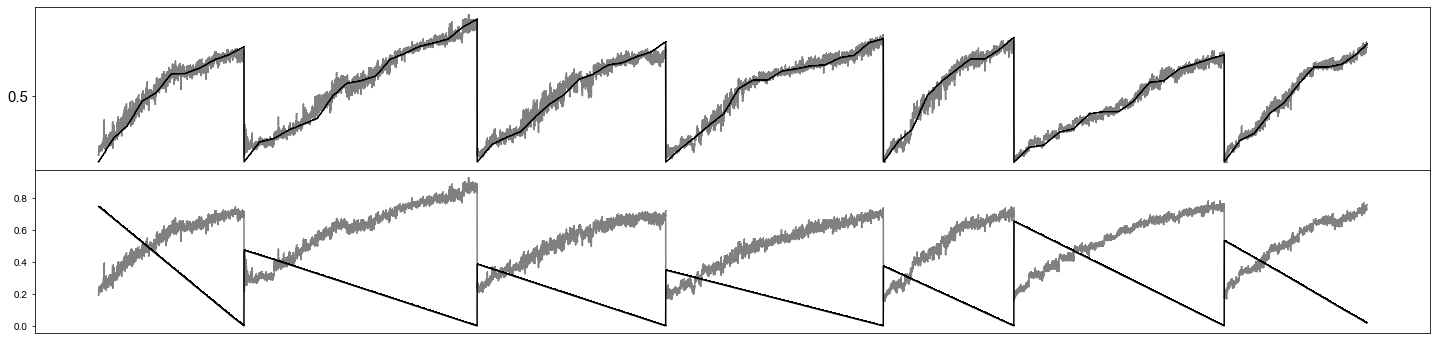

time1 =   1.8091402053833008 sample_num 1024
loss_test_avg 0.015192541
percent_test_avg 19.306185841560364 %


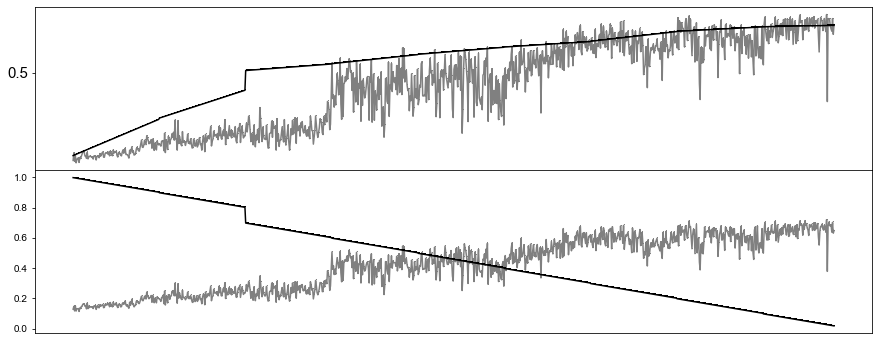

In [2]:
#
import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time

file_index = 1
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径

DOCUMENT_RESULT_PATH = 'results/comparation/loss function/'+str(file_index)+'/'
MODEL_LOAD_PATH = DOCUMENT_RESULT_PATH + 'all.h5'
PHYSICINFOMED_SAVEPATH = DOCUMENT_RESULT_PATH + 'all_result.npy'
    
load_flag = 1 ########################################1:重新加载模型，0：不加载##########################

if load_flag == 1:
    #信号层级关系
    SIGNAL_LENGTH_1 = 1536
    SIGNAL_LENGTH_2 = 64
    SIGNAL_LENGTH_3 = 8

    #输入数据
    INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
    INPUT_NUM = INPUT_SIZE[1]
    SCALE_NUM_FORCE = 3 #小波分解级数
    WAVELET_HIGHFREQ = 'db2'
    WAVELET_LOWFREQ = 'db6'
    # NOISE_FILTER_PERCENT = 90
    ATTENTION_RANGE = 24
    WEAR_SIZE = 1
    LIFE_SIZE = 2
    BATCH_SIZE = 64

    def wavelet_transform(data, scale_num):
        coeffs = np.arange(2).tolist()
        for j in range(np.shape(data)[2]):
            sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
            coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
            coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
            coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
            coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
    #         for i in range(1, scale_num+1):       #高频去噪
    #             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
            coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

            if j == 0:
                coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
                coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
            else:
                coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
                coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
        return coeffs

    class lowhigh_freq_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(lowhigh_freq_Attention,self).build(input_shape)
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
            value = x[:, 1:ATTENTION_RANGE+1]
            key = x[:, ATTENTION_RANGE+1:]
    #         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
            scores = tf.matmul(query, key, transpose_b=True)
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.matmul(distribution, value)
    #         print('value_weighted1', np.shape(value_weighted))
            value_weighted = tf.reduce_sum(value_weighted, axis=1)
    #         print('value_weighted2', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape

    class temporal_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(temporal_Attention,self).build(input_shape)
            self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
    #         print('query', np.shape(query))
    #         print('self.u_query', np.shape(self.u_query))
            key = x[:, 1:]
            scores1 = tf.matmul(query, key, transpose_b=True)
    #         print('scores1', np.shape(scores1))
            scores2 = tf.matmul(self.u_query, key, transpose_b=True)
    #         print('scores2', np.shape(scores2))
            scores = scores1 + scores2
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
    #         print('value_weighted1', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape

    X_train_set=np.load(TRAINDATA_LOADPATH)
    Y_train_set = np.load(TRAINLABEL_LOADPATH)
    Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
    X_test_set=np.load(TESTDATA_LOADPATH)
    Y_test_set = np.load(TESTLABEL_LOADPATH)
    Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

    #validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
    X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
    Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
    PHY_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
    X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
    PHY_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1:]# [拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]

    coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
    coeffs_lowfreq_train = coeffs_train_force[0]
    coeffs_highfreq_train = coeffs_train_force[1]
    coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
    coeffs_lowfreq_test = coeffs_test_force[0]
    coeffs_highfreq_test = coeffs_test_force[1]  

    ################################################### 模型读取及预测 ##################################################
    predictor = keras.models.load_model(MODEL_LOAD_PATH, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                         'temporal_Attention':temporal_Attention})

################################################### 波形显示 ##################################################
fig_x = 15
fig_y = 6
size = 15
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}

#train
wear_pre_train, life_pre_train = predictor.predict([coeffs_lowfreq_train, coeffs_highfreq_train], batch_size = BATCH_SIZE)
print('wear_pre_train', np.shape(wear_pre_train))
print('life_pre_train', np.shape(life_pre_train))

axis = np.linspace(1, np.shape(wear_pre_train)[0], np.shape(wear_pre_train)[0])
print('loss_train_avg', np.mean(np.square(wear_pre_train[:, 0] - Y_train)))
print('percent_train_avg', np.mean(np.abs(wear_pre_train[:, 0] - Y_train)/Y_train)*100, '%')
plt.figure(figsize=(25, 6))
plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(2,1,1)
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_train[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_train, marker = ',', color = 'black')
plt.subplot(2,1,2)
plt.xticks([])  #去掉纵坐标值
plt.plot(axis, life_pre_train[:, 0], marker = ',', color = 'gray')
plt.plot(axis, PHY_train[:, -1], marker = ',', color = 'black')
plt.show()

#test
time_start = time.time()
wear_pre_test, life_pre_test = predictor.predict([coeffs_lowfreq_test, coeffs_highfreq_test], batch_size = BATCH_SIZE)
print('time1 =  ', time.time()-time_start, 'sample_num', np.shape(coeffs_lowfreq_test)[0])

axis = np.linspace(1, np.shape(wear_pre_test)[0], np.shape(wear_pre_test)[0])
print('loss_test_avg', np.mean(np.square(wear_pre_test[:, 0] - Y_test)))
print('percent_test_avg', np.mean(np.abs(wear_pre_test[:, 0] - Y_test)/Y_test)*100, '%')
plt.figure(figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(2,1,1)
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_test[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_test, marker = ',', color = 'black')
plt.subplot(2,1,2)
plt.xticks([])  #去掉纵坐标值
plt.plot(axis, life_pre_test[:, 0], marker = ',', color = 'gray')
plt.plot(axis, PHY_test[:, -1], marker = ',', color = 'black')
# plt.savefig(DOCUMENT_RESULT_PATH + 'test_output.eps')
plt.show()

np.save(PHYSICINFOMED_SAVEPATH, wear_pre_test[:, 0])


## 结果比较

results/comparation/loss function//1/without_result.npy
1
mAPE
baseline:  4.935337603092194 %
without:  17.454153299331665 %
phywear:  18.99893879890442 %
life_phywear:  25.279688835144043 %
all:  19.306185841560364 %
mFPE
baseline:  1.9678411 um
without:  8.529249 um
phywear:  8.93728 um
life_phywear:  13.2433195 um
all:  9.5086975 um
MFPE
baseline:  10.981909 um
without:  16.184402 um
phywear:  26.675198 um
life_phywear:  29.120468 um
all:  31.741028 um


results/comparation/loss function//2/without_result.npy
2
mAPE
baseline:  4.480458423495293 %
without:  3.646889701485634 %
phywear:  28.145429491996765 %
life_phywear:  8.281619101762772 %
all:  8.33004117012024 %
mFPE
baseline:  2.1228597 um
without:  1.5998685 um
phywear:  12.302072 um
life_phywear:  3.0178483 um
all:  3.1175346 um
MFPE
baseline:  5.4849663 um
without:  6.224085 um
phywear:  25.480793 um
life_phywear:  16.597403 um
all:  19.262304 um


results/comparation/loss function//3/without_result.npy
3
mAPE
baseline:  5.30

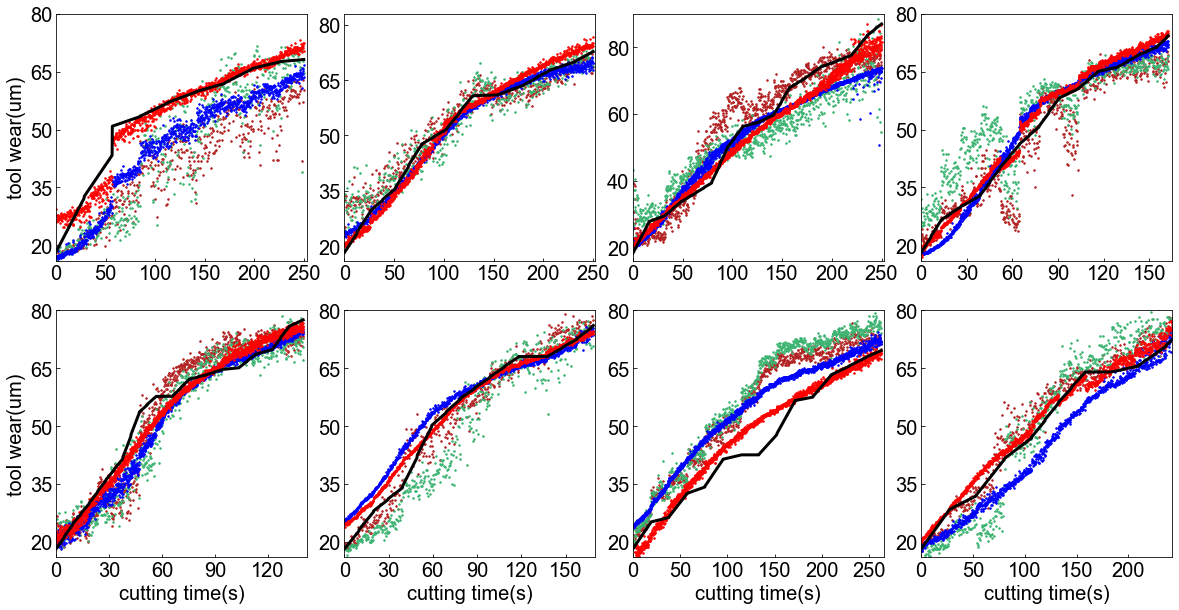

baseline: mAPE,  5.298972548916936 % mFPE 2.3424732983112335 um MFPE 7.770420789718628 um
without: mAPE,  10.291266581043601 % mFPE 4.541934639215469 um MFPE 14.627784967422485 um
phywear: mAPE,  15.418398845940828 % mFPE 6.709956496953964 um MFPE 19.04474973678589 um
life_phywear: mAPE,  12.126816809177399 % mFPE 5.665832728147507 um MFPE 21.225498914718628 um
all: mAPE,  14.588499628007412 % mFPE 6.44336599111557 um MFPE 23.952187299728394 um


In [3]:
#leave-one-out输出

import pywt
import numpy as np
import matplotlib.pyplot as plt
import xlrd

BASELINE_LOADPATH = ['results/prediction/1/physicsinformed1_result.npy', 'results/prediction/2/physicsinformed1_result.npy',
                     'results/prediction/3/physicsinformed1_result.npy', 'results/prediction/4/physicsinformed1_result.npy',
                     'results/prediction/5/physicsinformed1_result.npy', 'results/prediction/6/physicsinformed1_result.npy', 
                     'results/prediction/7/physicsinformed1_result.npy', 'results/prediction/8/physicsinformed1_result.npy']
DOCUMENT_RESULT_PATH = 'results/comparation/loss function/'
WITHOUT_LOADPATH = [DOCUMENT_RESULT_PATH +'/1/without_result.npy', DOCUMENT_RESULT_PATH +'/2/without_result.npy', 
                    DOCUMENT_RESULT_PATH +'/3/without_result.npy', DOCUMENT_RESULT_PATH +'/4/without_result.npy', 
                    DOCUMENT_RESULT_PATH +'/5/without_result.npy', DOCUMENT_RESULT_PATH +'/6/without_result.npy', 
                    DOCUMENT_RESULT_PATH +'/7/without_result.npy', DOCUMENT_RESULT_PATH +'/8/without_result.npy']
PHYWEAR_LOADPATH = [DOCUMENT_RESULT_PATH +'/1/phywear_result.npy', DOCUMENT_RESULT_PATH +'/2/phywear_result.npy', 
                    DOCUMENT_RESULT_PATH +'/3/phywear_result.npy', DOCUMENT_RESULT_PATH +'/4/phywear_result.npy', 
                    DOCUMENT_RESULT_PATH +'/5/phywear_result.npy', DOCUMENT_RESULT_PATH +'/6/phywear_result.npy', 
                    DOCUMENT_RESULT_PATH +'/7/phywear_result.npy', DOCUMENT_RESULT_PATH +'/8/phywear_result.npy']
LIFEPHYWEAR_LOADPATH = [DOCUMENT_RESULT_PATH +'/1/life_phywear_result.npy', DOCUMENT_RESULT_PATH +'/2/life_phywear_result.npy', 
                        DOCUMENT_RESULT_PATH +'/3/life_phywear_result.npy', DOCUMENT_RESULT_PATH +'/4/life_phywear_result.npy', 
                        DOCUMENT_RESULT_PATH +'/5/life_phywear_result.npy', DOCUMENT_RESULT_PATH +'/6/life_phywear_result.npy', 
                        DOCUMENT_RESULT_PATH +'/7/life_phywear_result.npy', DOCUMENT_RESULT_PATH +'/8/life_phywear_result.npy']
ALL_LOADPATH = [DOCUMENT_RESULT_PATH +'/1/all_result.npy', DOCUMENT_RESULT_PATH +'/2/all_result.npy', 
                DOCUMENT_RESULT_PATH +'/3/all_result.npy', DOCUMENT_RESULT_PATH +'/4/all_result.npy', 
                DOCUMENT_RESULT_PATH +'/5/all_result.npy', DOCUMENT_RESULT_PATH +'/6/all_result.npy', 
                DOCUMENT_RESULT_PATH +'/7/all_result.npy', DOCUMENT_RESULT_PATH +'/8/all_result.npy']
LABEL_LOADPATH = ['dataset/dataset1/test_label1.npy', 'dataset/dataset2/test_label1.npy', 'dataset/dataset3/test_label1.npy', 
                  'dataset/dataset4/test_label1.npy', 'dataset/dataset5/test_label1.npy', 'dataset/dataset6/test_label1.npy', 
                  'dataset/dataset7/test_label1.npy', 'dataset/dataset8/test_label1.npy']

FIG_SAVEPATH = 'results/comparation/loss function/test_train_result.svg'
BATCH_SIZE = 64


CUTTING_TIME = [250, 250, 250, 162.5, 140, 168.75, 262.5, 250]
xlim = {'1': 253, '2': 252, '3': 252, '4': 165,
         '5': 142, '6': 170,'7': 265, '8': 242}
ylim = {'1': [16, 80], '2': [16, 83], '3': [16, 90], '4': [16, 80],
         '5': [16, 80], '6': [16, 80], '7': [16, 80], '8': [16, 80]}
xticks = {'1': [0, 50, 100, 150, 200, 250], '2': [0, 50, 100, 150, 200, 250],
         '3': [0, 50, 100, 150, 200, 250], '4': [0, 30, 60, 90, 120, 150],
         '5': [0, 30, 60, 90, 120, 150], '6': [0, 30, 60, 90, 120, 150],
         '7': [0, 50, 100, 150, 200, 250], '8': [0, 50, 100, 150, 200, 250]}
yticks = {'1': [20, 35, 50, 65, 80], '2': [20, 35, 50, 65, 80],
         '3': [20, 40, 60, 80, 100], '4': [20, 35, 50, 65, 80],
         '5': [20, 35, 50, 65, 80], '6': [20, 35, 50, 65, 80],
         '7': [20, 35, 50, 65, 80], '8': [20, 35, 50, 65, 80]}

x_y_label_size = 20
x_y_stick_size = 20
font = {'family':'Arial', 'weight':'normal', 'size':20}
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.15, hspace=0.2)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

storage_list = np.zeros([8, 15])
for file_index in range(1, 9):
    #磨损标签
    Y_test_set = np.load(LABEL_LOADPATH[file_index-1])
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]*1000
    #信息融合模型结果
    baseline_result = np.load(BASELINE_LOADPATH[file_index-1]) * 100
    without_result = np.load(WITHOUT_LOADPATH[file_index-1]) * 100
    print(WITHOUT_LOADPATH[file_index-1])
    phywear_result = np.load(PHYWEAR_LOADPATH[file_index-1]) * 100
    life_phywear_result = np.load(LIFEPHYWEAR_LOADPATH[file_index-1]) * 100
    all_result = np.load(ALL_LOADPATH[file_index-1]) * 100
    
    print(file_index)
    print('mAPE')
    baseline = np.mean(np.abs((baseline_result - Y_test)/Y_test))*100
    without = np.mean(np.abs((without_result - Y_test)/Y_test))*100
    phywear = np.mean(np.abs((phywear_result - Y_test)/Y_test))*100
    life_phywear = np.mean(np.abs((life_phywear_result - Y_test)/Y_test))*100
    all = np.mean(np.abs((all_result - Y_test)/Y_test))*100
    storage_list[file_index-1, :5] = np.array([baseline, without, phywear, life_phywear, all])
    print('baseline: ', baseline, '%')
    print('without: ', without, '%')
    print('phywear: ', phywear, '%')
    print('life_phywear: ', life_phywear, '%')
    print('all: ', all, '%')
    
    print('mFPE')
    baseline = np.mean(np.abs(baseline_result - Y_test))
    without = np.mean(np.abs(without_result - Y_test))
    phywear = np.mean(np.abs(phywear_result - Y_test))
    life_phywear = np.mean(np.abs(life_phywear_result - Y_test))
    all = np.mean(np.abs(all_result - Y_test))
    storage_list[file_index-1, 5:10] = np.array([baseline, without, phywear, life_phywear, all])
    print('baseline: ', baseline, 'um')
    print('without: ', without, 'um')
    print('phywear: ', phywear, 'um')
    print('life_phywear: ', life_phywear, 'um')
    print('all: ', all, 'um')
    
    print('MFPE')
    baseline = np.max(np.abs(baseline_result - Y_test))
    without = np.max(np.abs(without_result - Y_test))
    phywear = np.max(np.abs(phywear_result - Y_test))
    life_phywear = np.max(np.abs(life_phywear_result - Y_test))
    all = np.max(np.abs(all_result - Y_test))
    storage_list[file_index-1, 10:15] = np.array([baseline, without, phywear, life_phywear, all])
    print('baseline: ', baseline, 'um')
    print('without: ', without, 'um')
    print('phywear: ', phywear, 'um')
    print('life_phywear: ', life_phywear, 'um')
    print('all: ', all, 'um')
    print('\n')

    plt.subplot(2,4,file_index)
    axis = np.linspace(0, CUTTING_TIME[file_index-1], num=np.shape(Y_test)[0]+1)[1:]
    plt.plot(axis[::2], life_phywear_result[::2],  '.', markersize=3, color='firebrick', label = 'life phywear')
    plt.plot(axis[::2], all_result[::2], '.', markersize=3, color='mediumseagreen', label = 'all')
    plt.plot(axis, without_result, '.', markersize=3, color='blue', label = 'without')
#     plt.plot(axis[::2], phywear_result[::2], linewidth=1.5, color='orange', label = 'phywear')
    plt.plot(axis, baseline_result, '.', markersize=3, color='red', label = 'baseline')
    plt.plot(axis, Y_test, linewidth=3, color='black', label = 'actual wear')
    
    if file_index-1 == 4 or file_index-1 == 5 or file_index-1 == 6 or file_index-1 == 7:
        plt.xlabel('cutting time(s)', font)
    if file_index-1 == 0 or file_index-1 == 4:
        plt.ylabel('tool wear(um)', font)
    plt.tick_params(labelsize=x_y_label_size) #坐标及刻度设置
    plt.xticks(xticks[str(file_index)], fontproperties = 'Arial', size = x_y_stick_size)
    plt.yticks(yticks[str(file_index)], fontproperties = 'Arial', size = x_y_stick_size)
    plt.xlim(xmin=0, xmax=xlim[str(file_index)]), plt.ylim(ymin=ylim[str(file_index)][0], ymax=ylim[str(file_index)][1])
#     if file_index-1 == 7:
#         plt.legend(prop = font)
plt.savefig(FIG_SAVEPATH, bbox_inches='tight')#无空白边界
plt.show()


averge_index = np.mean(storage_list, axis = 0)
print('baseline: mAPE, ', averge_index[0], '%', 'mFPE', averge_index[5], 'um', 'MFPE', averge_index[10], 'um')
print('without: mAPE, ', averge_index[1], '%', 'mFPE', averge_index[6], 'um', 'MFPE', averge_index[11], 'um')
print('phywear: mAPE, ', averge_index[2], '%', 'mFPE', averge_index[7], 'um', 'MFPE', averge_index[12], 'um')
print('life_phywear: mAPE, ', averge_index[3], '%', 'mFPE', averge_index[8], 'um', 'MFPE', averge_index[13], 'um')
print('all: mAPE, ', averge_index[4], '%', 'mFPE', averge_index[9], 'um', 'MFPE', averge_index[14], 'um')

results/comparation/loss function//1/without_result.npy
results/comparation/loss function//7/without_result.npy


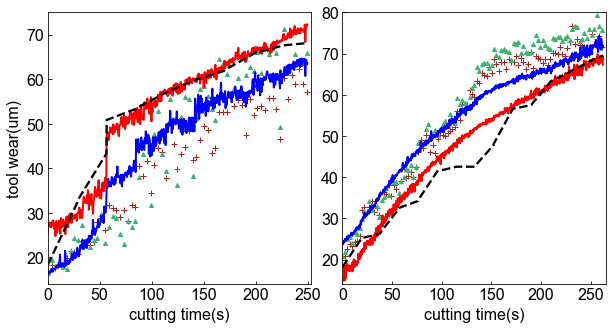

In [32]:
#leave-one-out输出

import pywt
import numpy as np
import matplotlib.pyplot as plt
import xlrd

BASELINE_LOADPATH = ['results/prediction/1/physicsinformed1_result.npy', 'results/prediction/2/physicsinformed1_result.npy',
                     'results/prediction/3/physicsinformed1_result.npy', 'results/prediction/4/physicsinformed1_result.npy',
                     'results/prediction/5/physicsinformed1_result.npy', 'results/prediction/6/physicsinformed1_result.npy', 
                     'results/prediction/7/physicsinformed1_result.npy', 'results/prediction/8/physicsinformed1_result.npy']
DOCUMENT_RESULT_PATH = 'results/comparation/loss function/'
WITHOUT_LOADPATH = [DOCUMENT_RESULT_PATH +'/1/without_result.npy', DOCUMENT_RESULT_PATH +'/2/without_result.npy', 
                    DOCUMENT_RESULT_PATH +'/3/without_result.npy', DOCUMENT_RESULT_PATH +'/4/without_result.npy', 
                    DOCUMENT_RESULT_PATH +'/5/without_result.npy', DOCUMENT_RESULT_PATH +'/6/without_result.npy', 
                    DOCUMENT_RESULT_PATH +'/7/without_result.npy', DOCUMENT_RESULT_PATH +'/8/without_result.npy']
PHYWEAR_LOADPATH = [DOCUMENT_RESULT_PATH +'/1/phywear_result.npy', DOCUMENT_RESULT_PATH +'/2/phywear_result.npy', 
                    DOCUMENT_RESULT_PATH +'/3/phywear_result.npy', DOCUMENT_RESULT_PATH +'/4/phywear_result.npy', 
                    DOCUMENT_RESULT_PATH +'/5/phywear_result.npy', DOCUMENT_RESULT_PATH +'/6/phywear_result.npy', 
                    DOCUMENT_RESULT_PATH +'/7/phywear_result.npy', DOCUMENT_RESULT_PATH +'/8/phywear_result.npy']
LIFEPHYWEAR_LOADPATH = [DOCUMENT_RESULT_PATH +'/1/life_phywear_result.npy', DOCUMENT_RESULT_PATH +'/2/life_phywear_result.npy', 
                        DOCUMENT_RESULT_PATH +'/3/life_phywear_result.npy', DOCUMENT_RESULT_PATH +'/4/life_phywear_result.npy', 
                        DOCUMENT_RESULT_PATH +'/5/life_phywear_result.npy', DOCUMENT_RESULT_PATH +'/6/life_phywear_result.npy', 
                        DOCUMENT_RESULT_PATH +'/7/life_phywear_result.npy', DOCUMENT_RESULT_PATH +'/8/life_phywear_result.npy']
ALL_LOADPATH = [DOCUMENT_RESULT_PATH +'/1/all_result.npy', DOCUMENT_RESULT_PATH +'/2/all_result.npy', 
                DOCUMENT_RESULT_PATH +'/3/all_result.npy', DOCUMENT_RESULT_PATH +'/4/all_result.npy', 
                DOCUMENT_RESULT_PATH +'/5/all_result.npy', DOCUMENT_RESULT_PATH +'/6/all_result.npy', 
                DOCUMENT_RESULT_PATH +'/7/all_result.npy', DOCUMENT_RESULT_PATH +'/8/all_result.npy']
LABEL_LOADPATH = ['dataset/dataset1/test_label1.npy', 'dataset/dataset2/test_label1.npy', 'dataset/dataset3/test_label1.npy', 
                  'dataset/dataset4/test_label1.npy', 'dataset/dataset5/test_label1.npy', 'dataset/dataset6/test_label1.npy', 
                  'dataset/dataset7/test_label1.npy', 'dataset/dataset8/test_label1.npy']

FIG_SAVEPATH = 'results/comparation/loss function/test_train_result.svg'
BATCH_SIZE = 64


CUTTING_TIME = [250, 250, 250, 162.5, 140, 168.75, 262.5, 250]
xlim = {'1': 253, '2': 252, '3': 252, '4': 165,
         '5': 142, '6': 170,'7': 265, '8': 242}
ylim = {'1': [14, 75], '2': [16, 83], '3': [16, 90], '4': [16, 77],
         '5': [16, 80], '6': [16, 80], '7': [14, 80], '8': [16, 80]}
xticks = {'1': [0, 50, 100, 150, 200, 250], '2': [0, 50, 100, 150, 200, 250],
         '3': [0, 50, 100, 150, 200, 250], '4': [0, 30, 60, 90, 120, 150],
         '5': [0, 30, 60, 90, 120, 150], '6': [0, 30, 60, 90, 120, 150],
         '7': [0, 50, 100, 150, 200, 250], '8': [0, 50, 100, 150, 200, 250]}
yticks = {'1': [20, 30, 40, 50, 60, 70], '2': [20, 35, 50, 65, 80],
         '3': [20, 40, 60, 80, 100], '4': [20, 30, 40, 50, 60, 70],
         '5': [20, 35, 50, 65, 80], '6': [20, 35, 50, 65, 80],
         '7': [20, 30, 40, 50, 60, 70, 80], '8': [20, 35, 50, 65, 80]}

x_y_label_size = 16
x_y_stick_size = 16
font = {'family':'Arial', 'weight':'normal', 'size':16}
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.12)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

test_index = np.array([0, 6])
for file_index in range(1, 3):
    #磨损标签
    Y_test_set = np.load(LABEL_LOADPATH[test_index[file_index-1]])
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]*1000
    #信息融合模型结果
    baseline_result = np.load(BASELINE_LOADPATH[test_index[file_index-1]]) * 100
    without_result = np.load(WITHOUT_LOADPATH[test_index[file_index-1]]) * 100
    print(WITHOUT_LOADPATH[test_index[file_index-1]])
    phywear_result = np.load(PHYWEAR_LOADPATH[test_index[file_index-1]]) * 100
    life_phywear_result = np.load(LIFEPHYWEAR_LOADPATH[test_index[file_index-1]]) * 100
    all_result = np.load(ALL_LOADPATH[test_index[file_index-1]]) * 100
    
    plt.subplot(1,2,file_index)
    axis = np.linspace(0, CUTTING_TIME[test_index[file_index-1]], num=np.shape(Y_test)[0]+1)[1:]
    plt.plot(axis[::15], life_phywear_result[::15],  '+', markersize=6, color='firebrick', label = 'life phywear')
    plt.plot(axis[::15], all_result[::15], '^', markersize=5, color='mediumseagreen', label = 'all')
    plt.plot(axis[::2], without_result[::2], linewidth=2, color='blue', label = 'without')
    plt.plot(axis[::2], baseline_result[::2], linewidth=2, color='red', label = 'baseline')
    plt.plot(axis, Y_test, '--', linewidth=2.3, color='black', label = 'actual wear')
    if file_index == 1:
        plt.ylabel('tool wear(um)', font)
    plt.xlabel('cutting time(s)', font)
    plt.tick_params(labelsize=x_y_label_size) #坐标及刻度设置
    plt.xticks(xticks[str(test_index[file_index-1]+1)], fontproperties = 'Arial', size = x_y_stick_size)
    plt.yticks(yticks[str(test_index[file_index-1]+1)], fontproperties = 'Arial', size = x_y_stick_size)
    plt.xlim(xmin=0, xmax=xlim[str(test_index[file_index-1]+1)])
    plt.ylim(ymin=ylim[str(test_index[file_index-1]+1)][0], ymax=ylim[str(test_index[file_index-1]+1)][1])
#     if file_index == 2:
#         plt.legend(prop = font)
plt.savefig(FIG_SAVEPATH, bbox_inches='tight')#无空白边界
plt.show()

In [ ]:
life             phywear, condition          红
无               phywear, condition, life    蓝
phywear          life,    condition          橘


life, phywear         condition              紫
life, phywear, condition                     绿

loss function，feature engineering都能提高监测准确度，且效果差不多。但feature engineering有助于预测值更符合磨损规律，且降低预测波动。
life作为loss function的效果最好，这可能由于wear和life之间关系紧密且存在确定性函数关系。而phywear的效果则受到物理模型准确度的限制。


life             phywear, condition          红
无               phywear, condition, life    蓝
life, phywear         condition              紫

phywear          life, condition             橘
life, phywear, condition                     绿

condition与wear之间的关系相对更加复杂，作为深层loss反而不利于刀具磨损预测。